Delta Hedging

Hedging a ATM call C with a time to maturity of T = 45 days. Stable T to work with.

Considering an Original Portfolio OP and a Replicating Porfolio RE. We have a long call C position in the OP and a short position delta 𝛥 = 𝜕𝐶/𝜕𝑆, of the underlying S. The initial values of OP and RE are C_0 and -𝛥_0 * S_0, respectively. 

First some imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

Then some function definitions for European call option prices, delta, and IV.

In [2]:
def black_scholes_call(S, K, T, r, sigma):
    """Calculate the Black-Scholes price of a European call option."""
    if T <= 0:
        return max(S - K, 0)
    elif sigma <= 0:
        return max(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return call_price

In [3]:
def black_scholes_delta(S, K, T, r, sigma):
    """Calculate the Black-Scholes delta of a European call option."""
    if T <= 0:
        return 1.0 if S > K else 0.0
    elif sigma <= 0:
        return 1.0 if S > K else 0.0
    else:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        delta = norm.cdf(d1)
        return delta

In [4]:
def implied_volatility(C_market, S, K, T, r, initial_guess=0.2):
    """Calculate the implied volatility using the Newton-Raphson method."""
    sigma = initial_guess
    for _ in range(100):
        C_model = black_scholes_call(S, K, T, r, sigma)
        vega = S * norm.pdf((np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))) * np.sqrt(T)
        sigma -= (C_model - C_market) / vega
        if abs(C_model - C_market) < 1e-6:
            break
    return sigma

def implied_volatility(C_market, S, K, T, r, tol=1e-6, max_iter=100):
    """Calculate the implied volatility using bisection method."""
    if C_market <= 0 or T <= 0:
        return 0.0  # Handle edge cases
    
    # For deep ITM/OTM, adjust bounds
    low = 0.001
    high = 2.0  # Upper bound for high vol
    
    for _ in range(max_iter):
        mid = (low + high) / 2
        C_model = black_scholes_call(S, K, T, r, mid)
        if abs(C_model - C_market) < tol:
            return mid
        elif C_model > C_market:
            high = mid
        else:
            low = mid
    
    return (low + high) / 2  # Return best approximation


Now the data collection,

In [5]:
def data_load(file_path):
    df = pd.read_feather(file_path)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()
    df.index.name = None 
    
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        
    return df

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def plot_spy_and_options(file_path, option_cols):
    # Ensure option_cols is a list
    if isinstance(option_cols, str):
        option_cols = [option_cols]
    
    # Load and process the data
    df = data_load(file_path)
    
    # Plot SPY candlesticks
    spy_df = df[["Open", "High", "Low", "Close"]]
    mc = mpf.make_marketcolors(up="#26a69a", down="#ef5350", edge="i", wick="i", volume="in")
    s = mpf.make_mpf_style(marketcolors=mc, gridstyle="--", facecolor="#f8f9fa")
    
    mpf.plot(
        spy_df,
        type="candle",
        style=s,
        title="SPY Candlesticks",
        ylabel="SPY Price ($)",
        figsize=(14, 7),
        tight_layout=True,
        figratio=(16, 9),
    )
    
    # Plot the specified options
    for option_col in option_cols:
        if option_col in df.columns:
            opt_df = df[[option_col]]
            fig, ax = plt.subplots(figsize=(14, 8))
            ax.plot(opt_df.index, opt_df[option_col], color="#1f77b4", lw=2, label=f"{option_col} Price")
            ax.set_title(f"SPY {option_col} Option Price", fontsize=14, weight="bold")
            ax.set_xlabel("Time", fontsize=12)
            ax.set_ylabel("Option Price ($)", fontsize=12)
            ax.grid(True, alpha=0.25)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.legend(loc="upper left")
            plt.tight_layout()
            plt.show()
        else:
            print(f"Option column '{option_col}' not found in the data.")

        # Check data range and size
    print(f"Data starts: {df.index.min()}")
    print(f"Data ends: {df.index.max()}")
    print(f"Number of days: {(df.index.max() - df.index.min()).days}")
    print(f"Number of data points: {len(df)}")
    print(f"Average points per day: {len(df) / (df.index.max() - df.index.min()).days:.1f}")

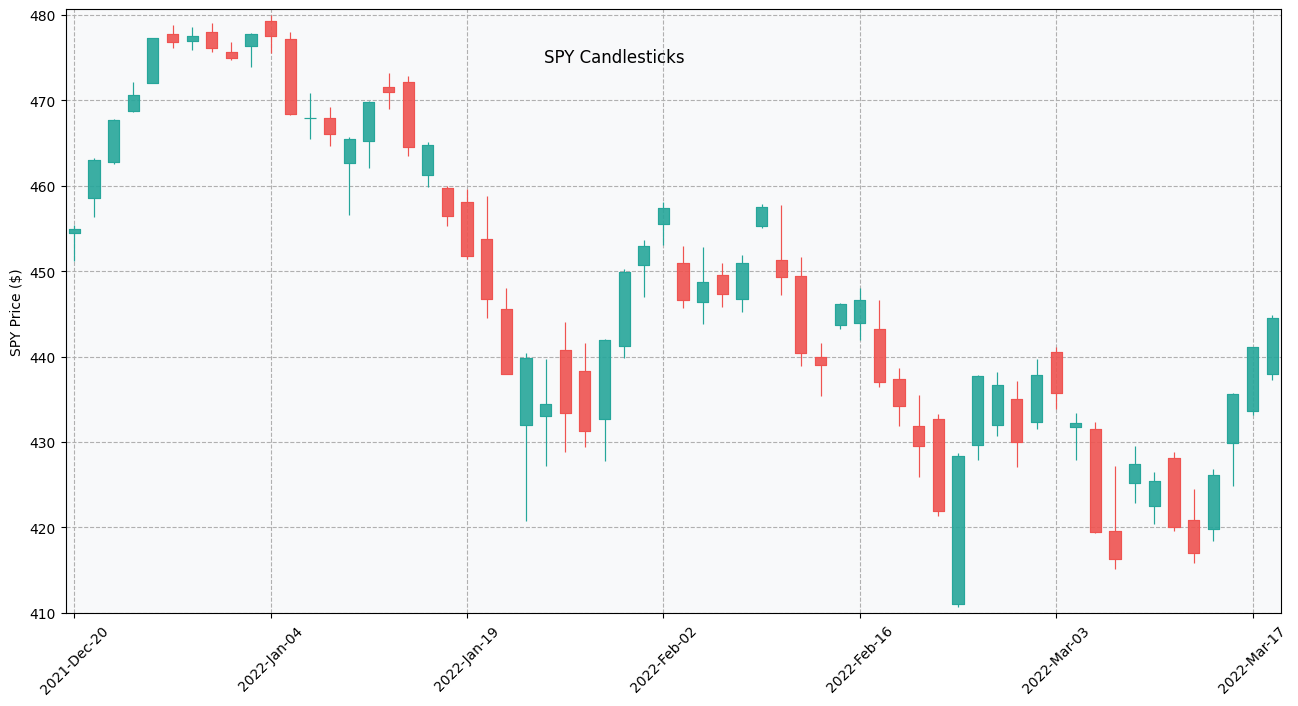

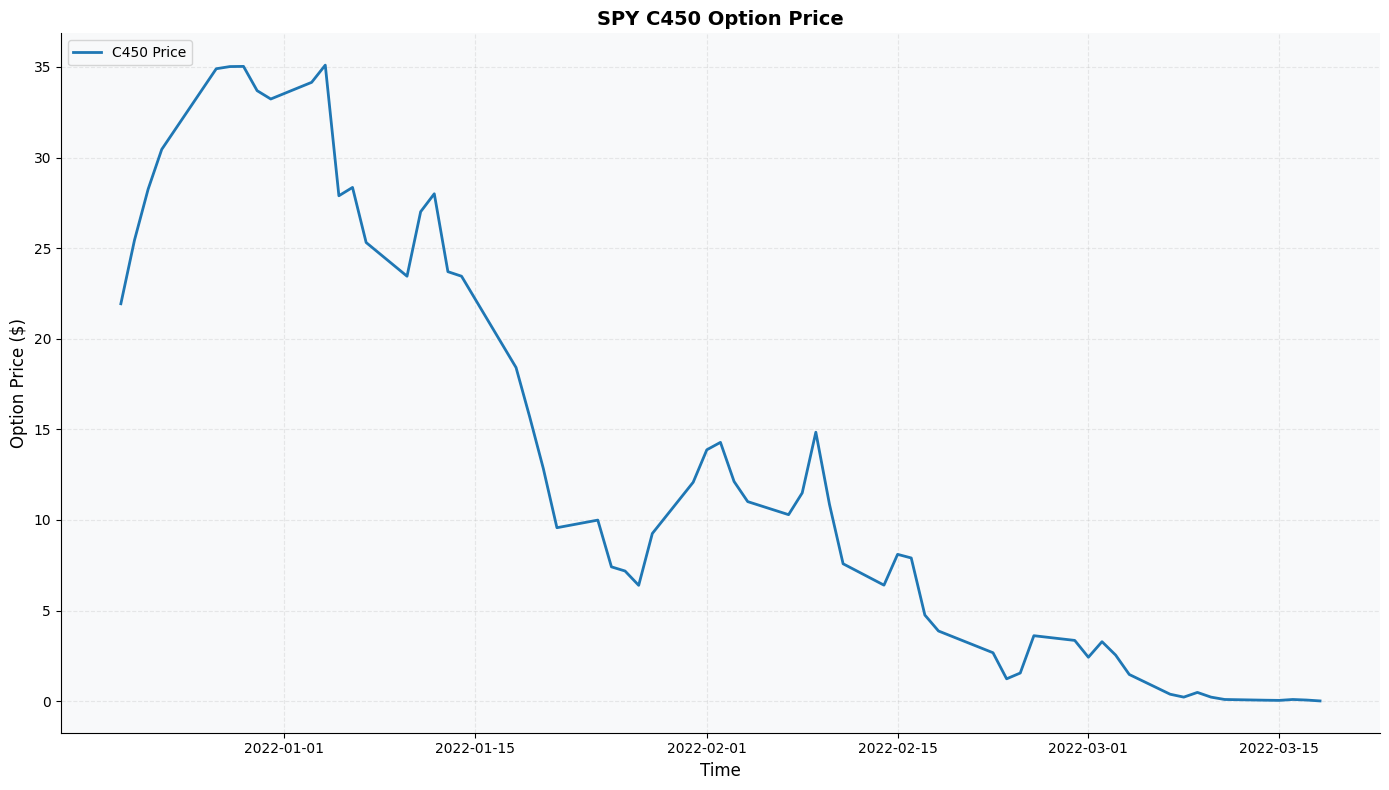

Data starts: 2021-12-20 00:00:00
Data ends: 2022-03-18 00:00:00
Number of days: 88
Number of data points: 62
Average points per day: 0.7


In [7]:
plot_spy_and_options("data/spy_031822_C470_C450.feather", ["C450"])

Delta hedging simulation,

In [8]:
def delta_hedging_strategy(df, start_idx, option_col, K, r, maturity, freq=1):
    df_hedge = df.iloc[start_idx:]
    OP = df[option_col].values[start_idx:]
    RE = df['Close'].values[start_idx:]
    n = len(df_hedge)

    deltas = np.zeros(n)
    A_errors = np.zeros(n - 1)
    iv_values = np.zeros(n)

    for i in range(n):
        T = (maturity - df_hedge.index[i]).days / 365
        iv = implied_volatility(OP[i], RE[i], K, T, r)
        iv_values[i] = iv
        deltas[i] = black_scholes_delta(RE[i], K, T, r, iv)

    for i in range(n-1):
        delta_idx = (i // freq) * freq
        current_delta = deltas[delta_idx]
        dC = OP[i+1] - OP[i]
        dR = RE[i+1] - RE[i]
        A_errors[i] = dC - current_delta * dR

    E = np.mean(A_errors**2)
    print(f"Mean Squared Hedging Error: {E:.4f}")

    return df_hedge, deltas, OP, RE, iv_values, A_errors

In [9]:
K = 450
r = 0.02
T = 45/365
option_col = 'C450'

df = data_load("data/spy_031822_C470_C450.feather")

maturity = df.index[-1]

start_idx = len(df) - 45

if start_idx < 0:
    start_idx = 0

print(f"Starting hedging at {df.index[start_idx]} with 45 trading days to expiry")
df_hedge, deltas, OP, RE, iv_values, A_errors = delta_hedging_strategy(df, start_idx, option_col, K, r, maturity)

Starting hedging at 2022-01-13 00:00:00 with 45 trading days to expiry
Mean Squared Hedging Error: 1.0101


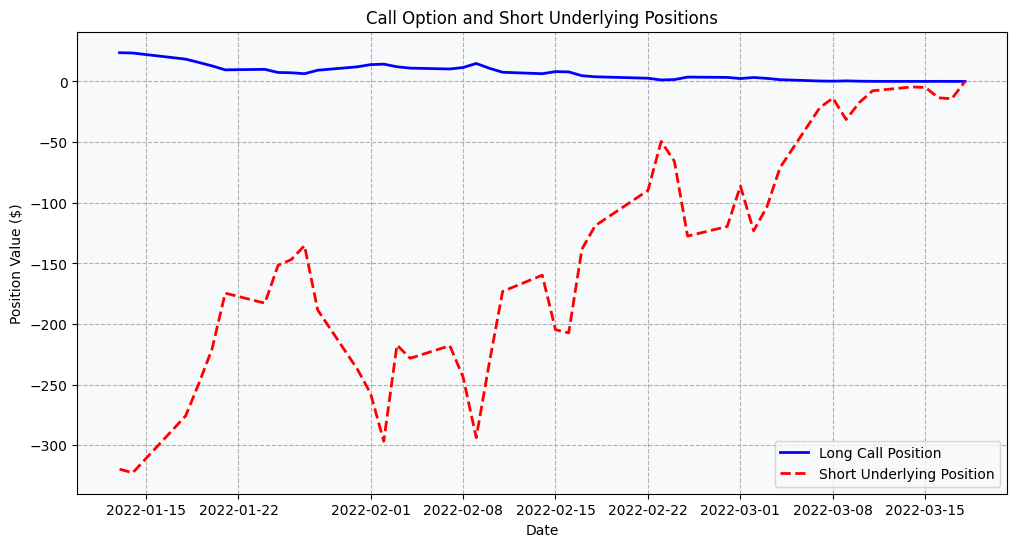

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, OP, 'b-', linewidth=2, label='Long Call Position')
plt.plot(df_hedge.index, -deltas * RE, 'r--', linewidth=2, label='Short Underlying Position')
plt.title('Call Option and Short Underlying Positions')
plt.xlabel('Date')
plt.ylabel('Position Value ($)')
plt.legend()
plt.grid(True)
plt.show()

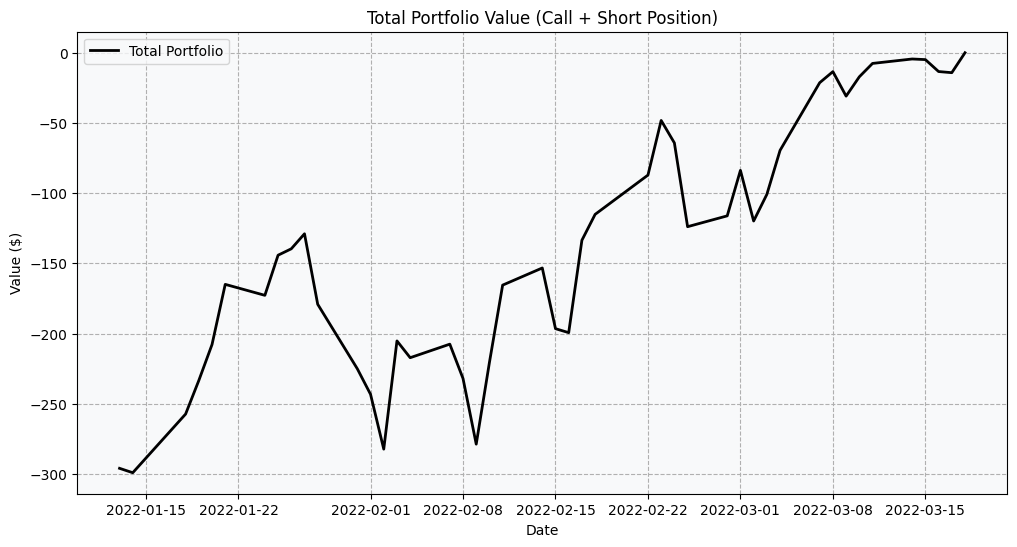

In [11]:
total_portfolio = OP + (-deltas * RE)
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, total_portfolio, 'k-', linewidth=2, label='Total Portfolio')
plt.title('Total Portfolio Value (Call + Short Position)')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)
plt.show()

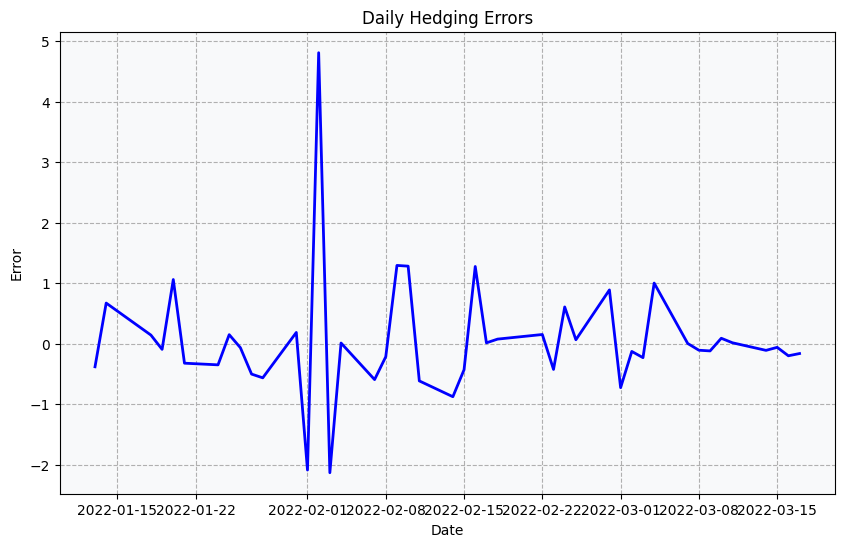

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(df_hedge.index[:-1], A_errors, 'b-', linewidth=2)
plt.title('Daily Hedging Errors')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True)
plt.show()


In [13]:
# Test different rehedging frequencies
for freq in [1, 2, 5]:
    df_hedge, deltas, OP, RE, iv_values, A_errors = delta_hedging_strategy(
        df, start_idx, 'C450', 450, 0.02, maturity, freq=freq
    )

Mean Squared Hedging Error: 1.0101
Mean Squared Hedging Error: 1.0024
Mean Squared Hedging Error: 0.8877


New data for some data with a bullish trend,

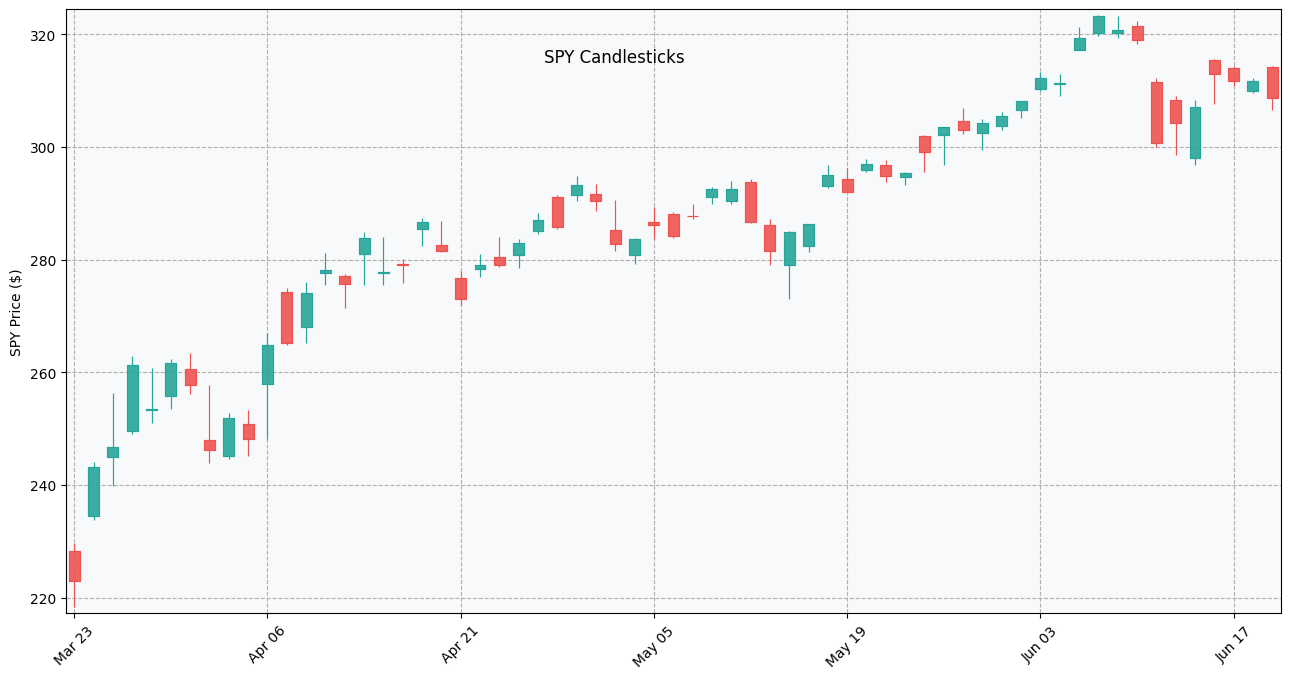

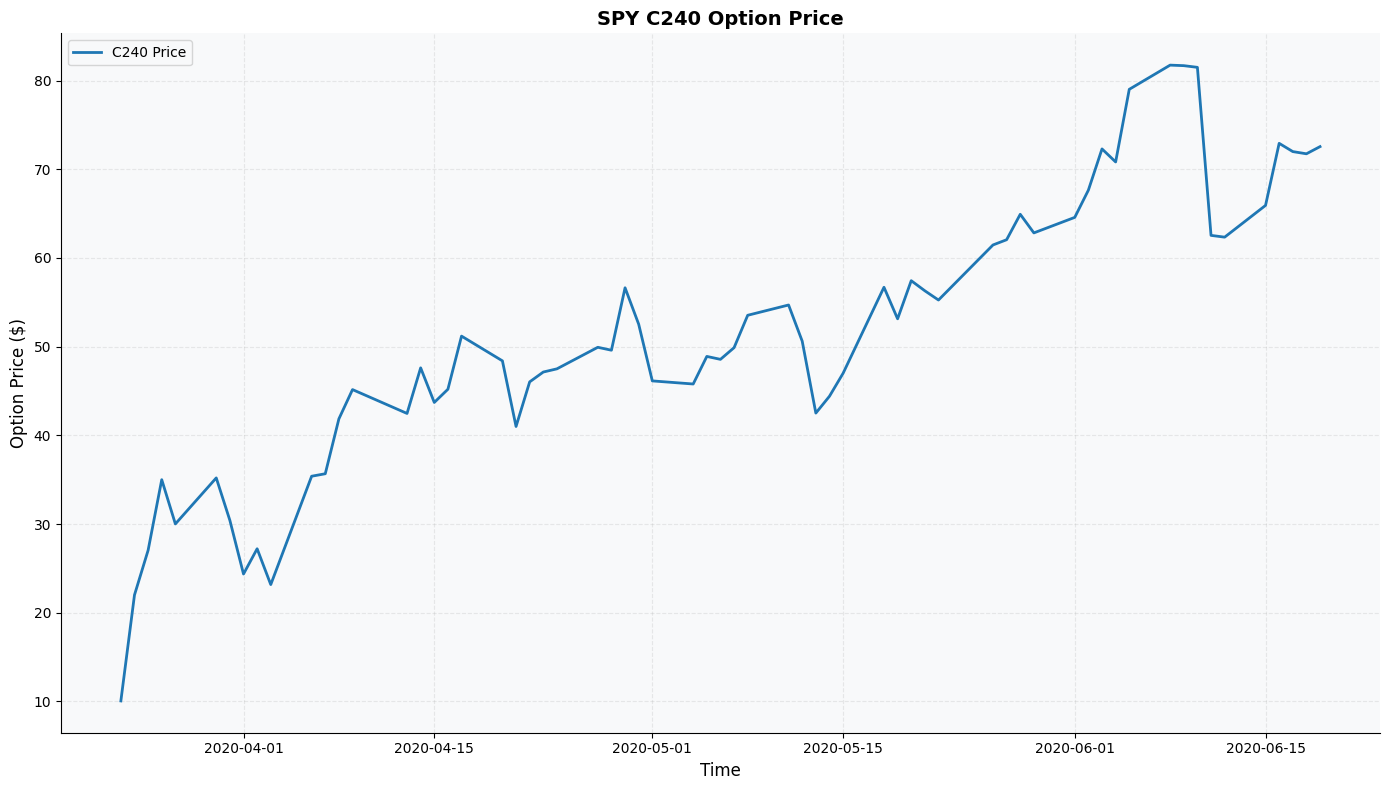

Data starts: 2020-03-23 00:00:00
Data ends: 2020-06-19 00:00:00
Number of days: 88
Number of data points: 63
Average points per day: 0.7


In [14]:
plot_spy_and_options("data/spy_061920_C240_C250_C260.feather", ["C240"])

In [15]:
K = 240
r = 0.02
T = 45/365
option_col = 'C240'

df = data_load("data/spy_061920_C240_C250_C260.feather")

maturity = df.index[-1]

start_idx = len(df) - 45

if start_idx < 0:
    start_idx = 0

print(f"Starting hedging at {df.index[start_idx]} with 45 trading days to expiry")
df_hedge, deltas, OP, RE, iv_values, A_errors = delta_hedging_strategy(df, start_idx, option_col, K, r, maturity)

Starting hedging at 2020-04-17 00:00:00 with 45 trading days to expiry
Mean Squared Hedging Error: 3.0702


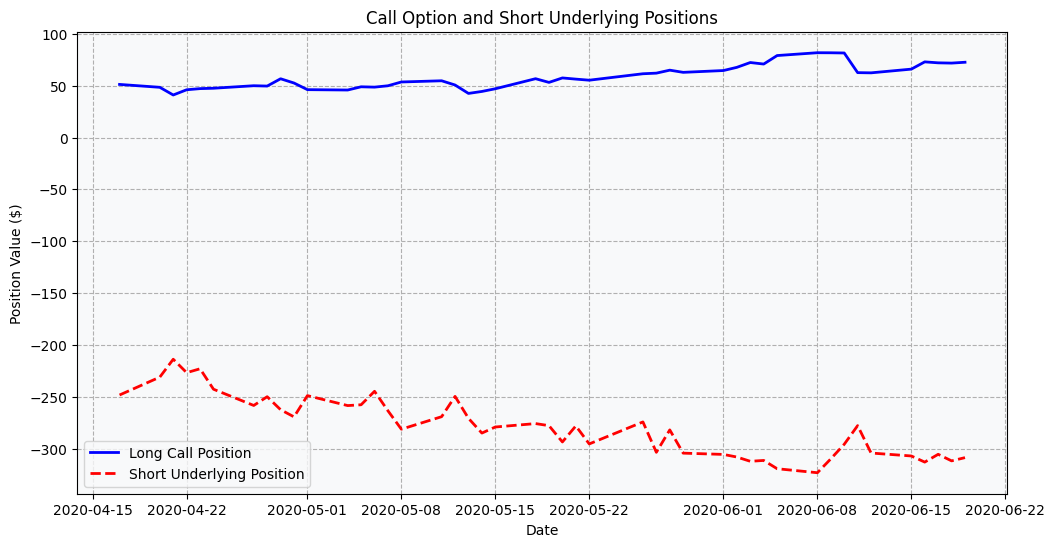

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, OP, 'b-', linewidth=2, label='Long Call Position')
plt.plot(df_hedge.index, -deltas * RE, 'r--', linewidth=2, label='Short Underlying Position')
plt.title('Call Option and Short Underlying Positions')
plt.xlabel('Date')
plt.ylabel('Position Value ($)')
plt.legend()
plt.grid(True)
plt.show()

Now a more realistic simulation, this has transaction costs.

In [17]:
def delta_hedging_strategy(df, start_idx, option_col, K, r, maturity, freq=1, 
                          transaction_cost_per_share=0.0, transaction_cost_percentage=0.0):
    df_hedge = df.iloc[start_idx:]
    OP = df[option_col].values[start_idx:]
    RE = df['Close'].values[start_idx:]
    n = len(df_hedge)

    deltas = np.zeros(n)
    iv_values = np.zeros(n)
    shares_held = np.zeros(n)
    cash_position = np.zeros(n)
    portfolio_values = np.zeros(n)
    cumulative_costs = np.zeros(n)
    pnl = np.zeros(n)

    # Calculate deltas and IV
    for i in range(n):
        T = (maturity - df_hedge.index[i]).days / 365
        iv = implied_volatility(OP[i], RE[i], K, T, r)
        iv_values[i] = iv
        deltas[i] = black_scholes_delta(RE[i], K, T, r, iv)

    # Initialize portfolio
    shares_held[0] = -deltas[0]  # Short position for delta hedging
    cash_position[0] = deltas[0] * RE[0] - OP[0]  # Cash from shorting shares minus call premium
    portfolio_values[0] = OP[0] + shares_held[0] * RE[0] + cash_position[0]  # Should be ~0
    pnl[0] = 0.0

    # Simulate hedging with costs
    for i in range(1, n):
        # Determine if we rehedge this period
        rehedge_period = (i // freq) * freq
        
        if i % freq == 0 or i == n-1:  # Rehedge at frequency or final period
            target_shares = -deltas[i]
            shares_to_trade = target_shares - shares_held[i-1]
            
            # Calculate transaction costs
            trade_value = abs(shares_to_trade) * RE[i]
            cost = (abs(shares_to_trade) * transaction_cost_per_share + 
                   trade_value * transaction_cost_percentage)
            
            # Update positions
            cash_position[i] = cash_position[i-1] - cost - shares_to_trade * RE[i]
            shares_held[i] = target_shares
            cumulative_costs[i] = cumulative_costs[i-1] + cost
        else:
            # No rehedging, maintain previous positions
            shares_held[i] = shares_held[i-1]
            cash_position[i] = cash_position[i-1]
            cumulative_costs[i] = cumulative_costs[i-1]
        
        # Calculate portfolio value and PnL
        portfolio_values[i] = OP[i] + shares_held[i] * RE[i] + cash_position[i]
        pnl[i] = portfolio_values[i] - portfolio_values[0]  # PnL relative to initial value

    # Calculate hedging errors (existing logic)
    A_errors = np.zeros(n - 1)
    for i in range(n-1):
        delta_idx = (i // freq) * freq
        current_delta = deltas[delta_idx]
        dC = OP[i+1] - OP[i]
        dR = RE[i+1] - RE[i]
        A_errors[i] = dC - current_delta * dR

    E = np.mean(A_errors**2)
    print(f"Mean Squared Hedging Error: {E:.4f}")
    print(f"Total Transaction Costs: {cumulative_costs[-1]:.2f}")
    print(f"Final PnL: {pnl[-1]:.2f}")

    return (df_hedge, deltas, OP, RE, iv_values, A_errors, 
            shares_held, cash_position, portfolio_values, cumulative_costs, pnl)


In [18]:
df = data_load("data/spy_061920_C240_C250_C260.feather")
maturity = df.index[-1]
start_idx = len(df) - 45

df_hedge, deltas, OP, RE, iv_values, A_errors, shares_held, cash_position, portfolio_values, cumulative_costs, pnl = delta_hedging_strategy(
    df, start_idx, 'C240', 240, 0.02, maturity, freq=1, 
    transaction_cost_per_share=0.01, transaction_cost_percentage=0.0005
)

Mean Squared Hedging Error: 3.0702
Total Transaction Costs: 0.23
Final PnL: -0.81


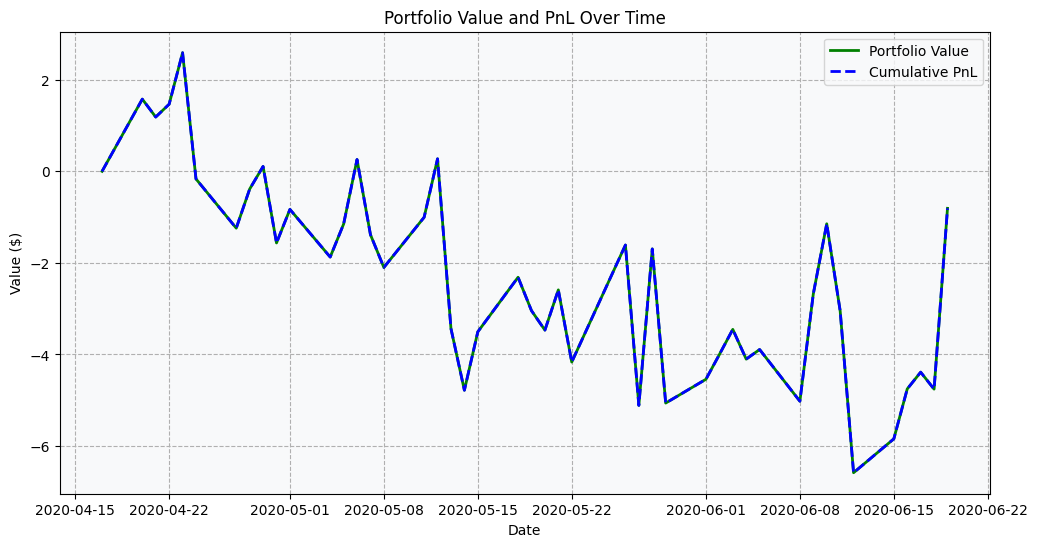

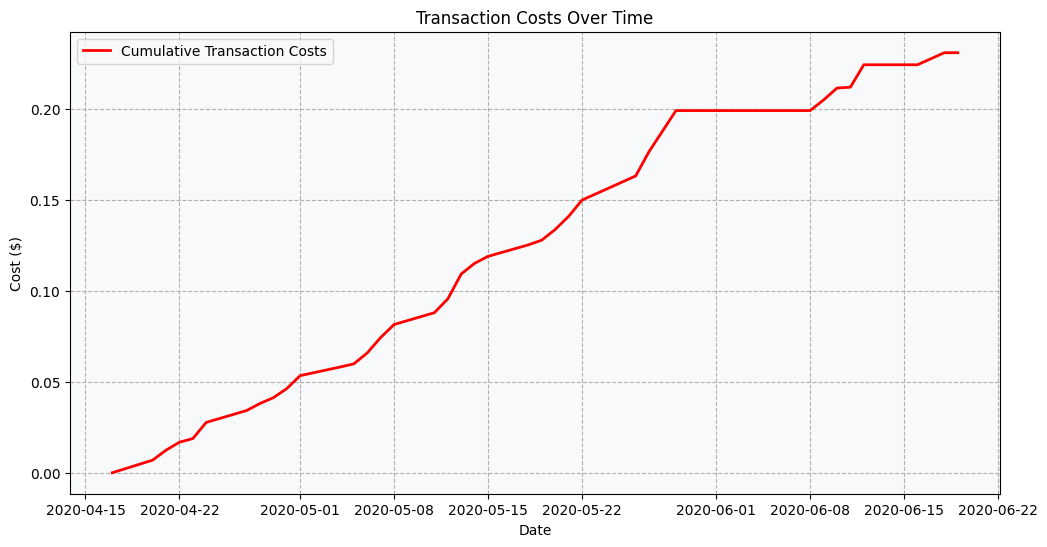

In [19]:
# Plot portfolio value and PnL
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, portfolio_values, 'g-', linewidth=2, label='Portfolio Value')
plt.plot(df_hedge.index, pnl, 'b--', linewidth=2, label='Cumulative PnL')
plt.title('Portfolio Value and PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative costs
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, cumulative_costs, 'r-', linewidth=2, label='Cumulative Transaction Costs')
plt.title('Transaction Costs Over Time')
plt.xlabel('Date')
plt.ylabel('Cost ($)')
plt.legend()
plt.grid(True)
plt.show()


Butterfly position,

In [20]:
def butterfly_delta_hedging_strategy(df, start_idx, option_cols, weights, strikes, r, maturity, freq=1, 
                                   transaction_cost_per_share=0.0, transaction_cost_percentage=0.0):
    """
    Delta hedge a butterfly spread: weights should be [1, -2, 1] for +1 C240, -2 C250, +1 C260
    option_cols: ['C240', 'C250', 'C260']
    strikes: [240, 250, 260]
    """
    df_hedge = df.iloc[start_idx:]
    RE = df['Close'].values[start_idx:]
    n = len(df_hedge)
    
    # Calculate butterfly position value and net delta
    OP = np.zeros(n)  # Butterfly position value
    net_deltas = np.zeros(n)
    iv_values = np.zeros((n, len(option_cols)))
    
    for i in range(n):
        T = (maturity - df_hedge.index[i]).days / 365
        position_value = 0
        net_delta = 0
        
        for j, (col, weight, K) in enumerate(zip(option_cols, weights, strikes)):
            C = df[col].values[start_idx + i]
            iv = implied_volatility(C, RE[i], K, T, r)
            iv_values[i, j] = iv
            delta = black_scholes_delta(RE[i], K, T, r, iv)
            
            position_value += weight * C
            net_delta += weight * delta
            
        OP[i] = position_value
        net_deltas[i] = net_delta
    
    # Initialize portfolio tracking
    shares_held = np.zeros(n)
    cash_position = np.zeros(n)
    portfolio_values = np.zeros(n)
    cumulative_costs = np.zeros(n)
    pnl = np.zeros(n)
    
    # Initial position
    shares_held[0] = -net_deltas[0]  # Hedge the net delta
    cash_position[0] = net_deltas[0] * RE[0] - OP[0]  # Cash from shorting shares minus butterfly premium
    portfolio_values[0] = OP[0] + shares_held[0] * RE[0] + cash_position[0]
    pnl[0] = 0.0
    
    # Simulate hedging
    for i in range(1, n):
        if i % freq == 0 or i == n-1:  # Rehedge
            target_shares = -net_deltas[i]
            shares_to_trade = target_shares - shares_held[i-1]
            
            trade_value = abs(shares_to_trade) * RE[i]
            cost = (abs(shares_to_trade) * transaction_cost_per_share + 
                   trade_value * transaction_cost_percentage)
            
            cash_position[i] = cash_position[i-1] - cost - shares_to_trade * RE[i]
            shares_held[i] = target_shares
            cumulative_costs[i] = cumulative_costs[i-1] + cost
        else:
            shares_held[i] = shares_held[i-1]
            cash_position[i] = cash_position[i-1]
            cumulative_costs[i] = cumulative_costs[i-1]
        
        portfolio_values[i] = OP[i] + shares_held[i] * RE[i] + cash_position[i]
        pnl[i] = portfolio_values[i] - portfolio_values[0]
    
    # Calculate hedging errors
    A_errors = np.zeros(n - 1)
    for i in range(n-1):
        delta_idx = (i // freq) * freq
        current_net_delta = net_deltas[delta_idx]
        dP = OP[i+1] - OP[i]  # Change in butterfly position
        dR = RE[i+1] - RE[i]
        A_errors[i] = dP - current_net_delta * dR
    
    E = np.mean(A_errors**2)
    print(f"Butterfly Position - Mean Squared Hedging Error: {E:.4f}")
    print(f"Total Transaction Costs: {cumulative_costs[-1]:.2f}")
    print(f"Final PnL: {pnl[-1]:.2f}")
    
    return (df_hedge, net_deltas, OP, RE, iv_values, A_errors, 
            shares_held, cash_position, portfolio_values, cumulative_costs, pnl)


Butterfly Position - Mean Squared Hedging Error: 2.9976
Total Transaction Costs: 0.24
Final PnL: 2.17


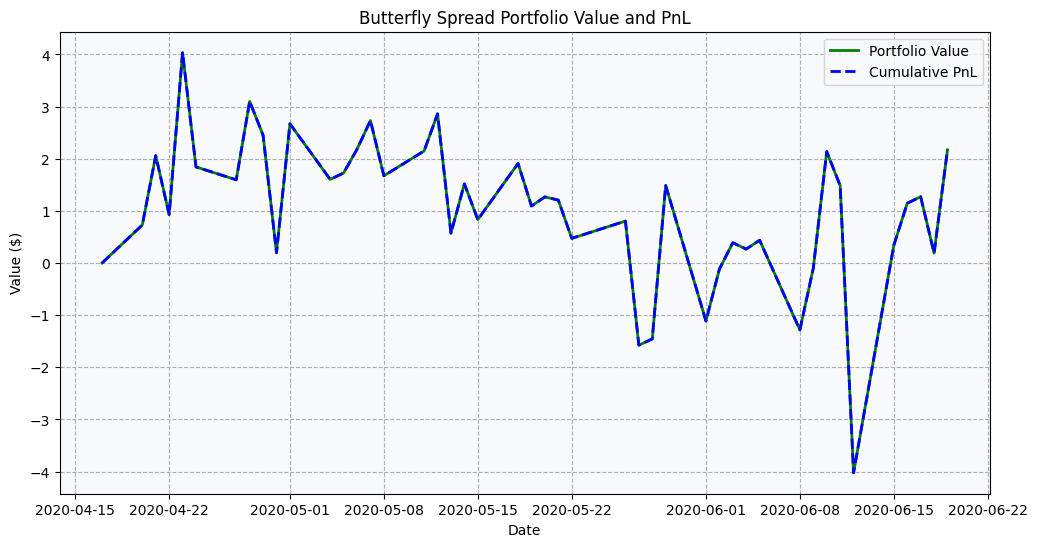

In [21]:
# Load the data
df = data_load("data/spy_061920_C240_C250_C260.feather")
maturity = df.index[-1]
start_idx = len(df) - 45
r = 0.02

# Butterfly: +1 C240, -2 C250, +1 C260
option_cols = ['C240', 'C250', 'C260']
weights = [1, -2, 1]
strikes = [240, 250, 260]

df_hedge, net_deltas, OP, RE, iv_values, A_errors, shares_held, cash_position, portfolio_values, cumulative_costs, pnl = butterfly_delta_hedging_strategy(
    df, start_idx, option_cols, weights, strikes, r, maturity, freq=1,
    transaction_cost_per_share=0.01, transaction_cost_percentage=0.0005
)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, portfolio_values, 'g-', linewidth=2, label='Portfolio Value')
plt.plot(df_hedge.index, pnl, 'b--', linewidth=2, label='Cumulative PnL')
plt.title('Butterfly Spread Portfolio Value and PnL')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)
plt.show()


Here is some longer range data, about 130 days to 160 days,

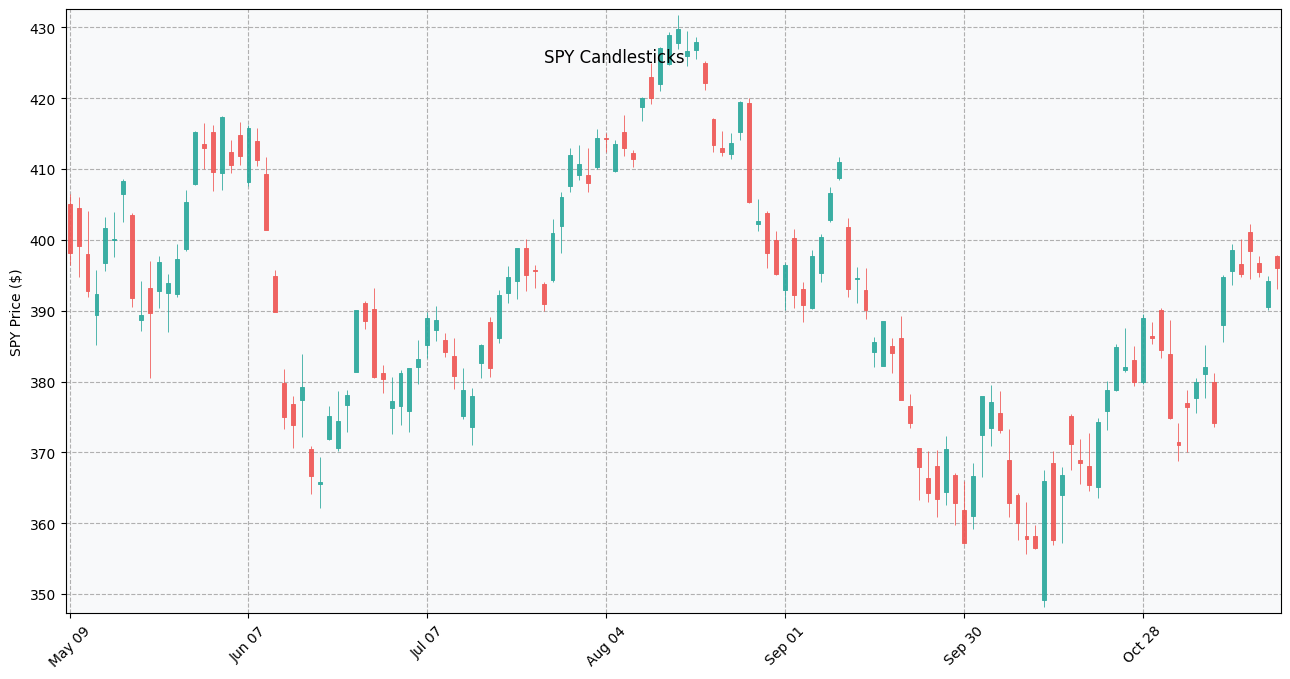

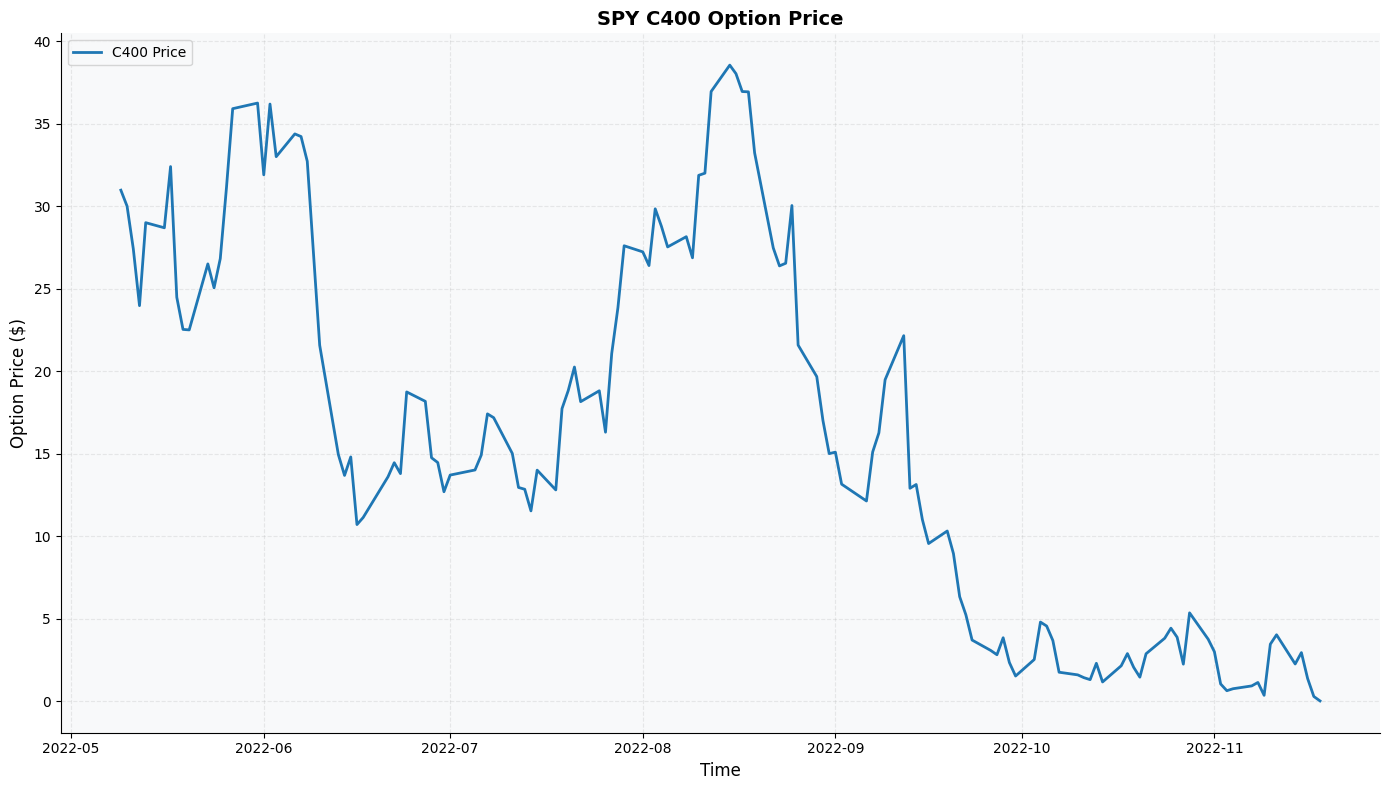

Data starts: 2022-05-09 00:00:00
Data ends: 2022-11-18 00:00:00
Number of days: 193
Number of data points: 136
Average points per day: 0.7


In [22]:
plot_spy_and_options("data/spy_111822_C380_C390_C400_136days.feather", ["C400"])

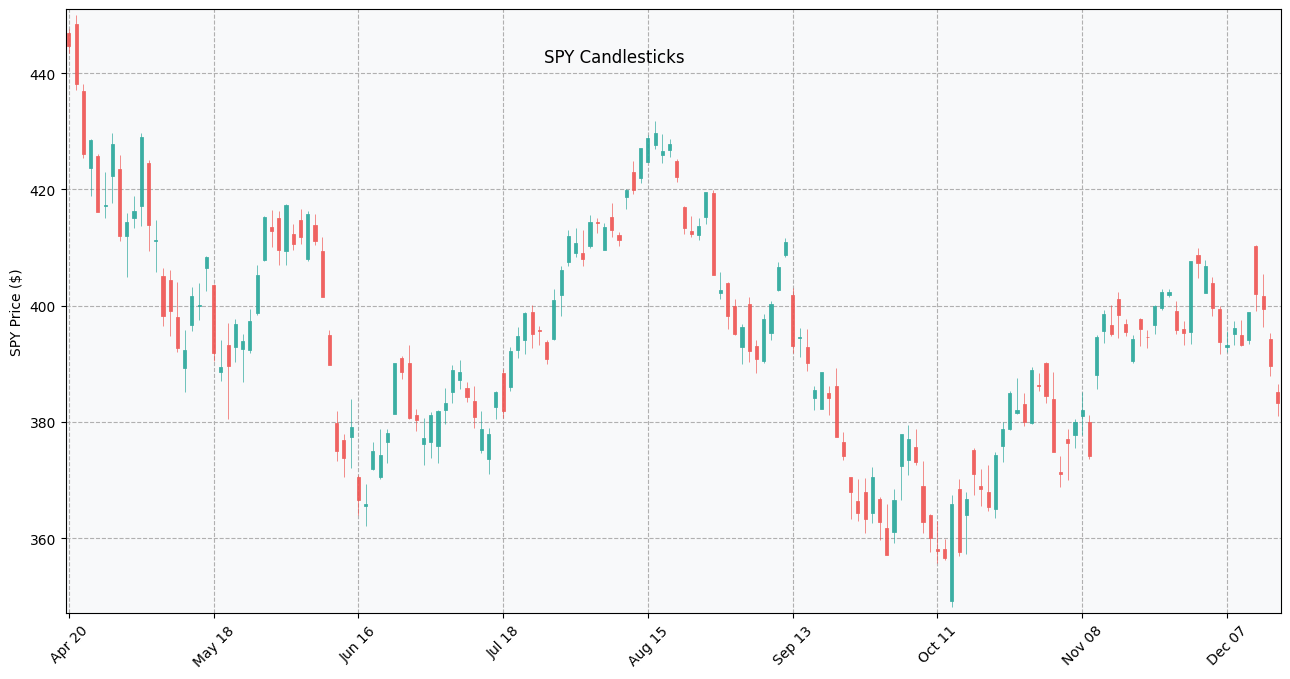

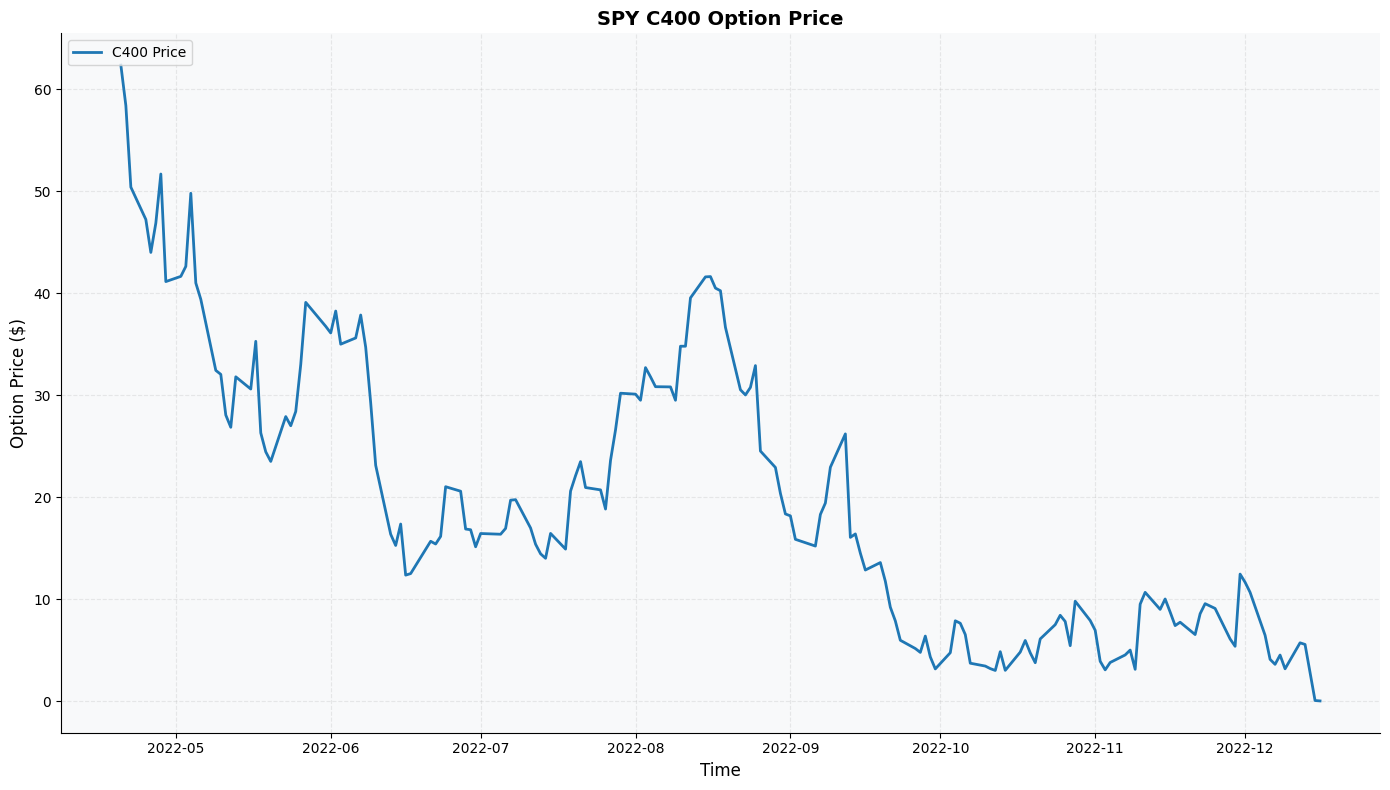

Data starts: 2022-04-20 00:00:00
Data ends: 2022-12-16 00:00:00
Number of days: 240
Number of data points: 168
Average points per day: 0.7


In [23]:
plot_spy_and_options("data/spy_121622_C380_C390_C400_168days.feather", ["C400"])

In [24]:
df = data_load("data/spy_121622_C380_C390_C400_168days.feather")
maturity = df.index[-1]
start_idx = len(df) - 90

df_hedge, deltas, OP, RE, iv_values, A_errors, shares_held, cash_position, portfolio_values, cumulative_costs, pnl = delta_hedging_strategy(
    df, start_idx, 'C400', 400, 0.02, maturity, freq=1, 
    transaction_cost_per_share=0.01, transaction_cost_percentage=0.0005
)

Mean Squared Hedging Error: 0.4823
Total Transaction Costs: 1.04
Final PnL: 0.34


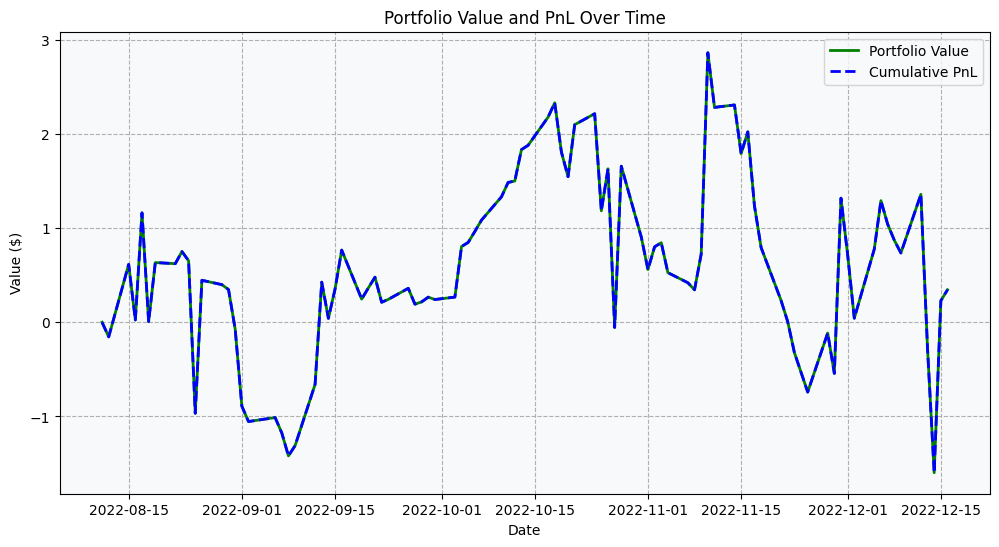

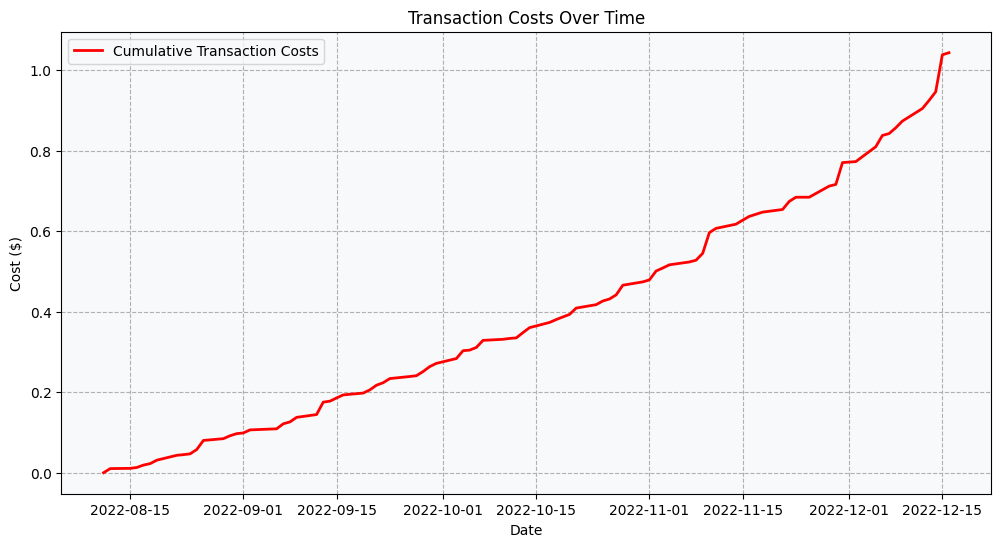

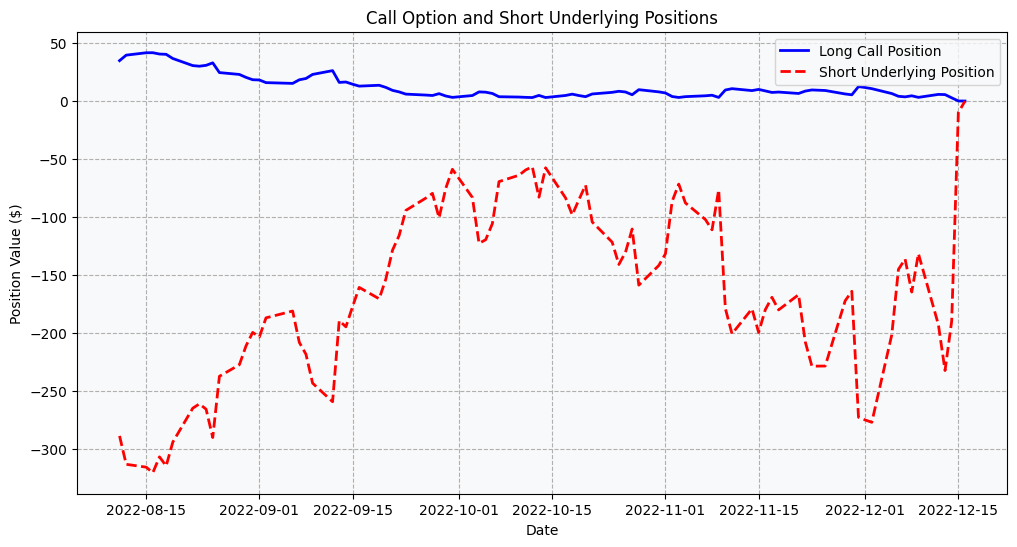

In [25]:
# Plot portfolio value and PnL
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, portfolio_values, 'g-', linewidth=2, label='Portfolio Value')
plt.plot(df_hedge.index, pnl, 'b--', linewidth=2, label='Cumulative PnL')
plt.title('Portfolio Value and PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative costs
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, cumulative_costs, 'r-', linewidth=2, label='Cumulative Transaction Costs')
plt.title('Transaction Costs Over Time')
plt.xlabel('Date')
plt.ylabel('Cost ($)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, OP, 'b-', linewidth=2, label='Long Call Position')
plt.plot(df_hedge.index, -deltas * RE, 'r--', linewidth=2, label='Short Underlying Position')
plt.title('Call Option and Short Underlying Positions')
plt.xlabel('Date')
plt.ylabel('Position Value ($)')
plt.legend()
plt.grid(True)
plt.show()

for delta-vega hedging we need two different call options C1 and C2 with varying maturities but the same strike,

In [26]:
def black_scholes_vega(S, K, T, r, sigma):
    """Calculate the Black-Scholes vega of a European call option."""
    if T <= 0 or sigma <= 0:
        return 0.0
    else:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)
        return vega

In [27]:
def delta_vega_hedging_strategy(df, start_idx, option_col1, option_col2, K, r, maturity1, maturity2, freq=1, 
                               transaction_cost_per_share=0.0, transaction_cost_percentage=0.0):
    df_hedge = df.iloc[start_idx:]
    OP1 = df[option_col1].values[start_idx:]
    OP2 = df[option_col2].values[start_idx:]
    RE = df['Close'].values[start_idx:]
    n = len(df_hedge)

    deltas1 = np.zeros(n)
    deltas2 = np.zeros(n)
    vegas1 = np.zeros(n)
    vegas2 = np.zeros(n)
    iv_values1 = np.zeros(n)
    iv_values2 = np.zeros(n)
    alphas = np.zeros(n)  # vega hedge ratio
    net_deltas = np.zeros(n)

    shares_held = np.zeros(n)
    option2_held = np.zeros(n)
    cash_position = np.zeros(n)
    portfolio_values = np.zeros(n)
    cumulative_costs = np.zeros(n)
    pnl = np.zeros(n)

    # Calculate deltas, vegas, and IVs
    for i in range(n):
        T1 = (maturity1 - df_hedge.index[i]).days / 365
        T2 = (maturity2 - df_hedge.index[i]).days / 365
        iv1 = implied_volatility(OP1[i], RE[i], K, T1, r)
        iv2 = implied_volatility(OP2[i], RE[i], K, T2, r)
        iv_values1[i] = iv1
        iv_values2[i] = iv2
        deltas1[i] = black_scholes_delta(RE[i], K, T1, r, iv1)
        deltas2[i] = black_scholes_delta(RE[i], K, T2, r, iv2)
        vegas1[i] = black_scholes_vega(RE[i], K, T1, r, iv1)
        vegas2[i] = black_scholes_vega(RE[i], K, T2, r, iv2)
        
        alphas[i] = vegas1[i] / vegas2[i] if vegas2[i] != 0 else 0
        net_deltas[i] = deltas1[i] - alphas[i] * deltas2[i]

    # Initialize portfolio
    shares_held[0] = -net_deltas[0]
    option2_held[0] = -alphas[0]  # Short the vega hedge option
    cash_position[0] = (net_deltas[0] * RE[0] + alphas[0] * OP2[0]) - OP1[0]
    portfolio_values[0] = OP1[0] + shares_held[0] * RE[0] + option2_held[0] * OP2[0] + cash_position[0]
    pnl[0] = 0.0

    # Simulate hedging
    for i in range(1, n):
        if i % freq == 0 or i == n-1:
            target_shares = -net_deltas[i]
            target_option2 = -alphas[i]
            shares_to_trade = target_shares - shares_held[i-1]
            option2_to_trade = target_option2 - option2_held[i-1]
            
            trade_value_shares = abs(shares_to_trade) * RE[i]
            trade_value_option2 = abs(option2_to_trade) * OP2[i]
            cost = (abs(shares_to_trade) * transaction_cost_per_share + 
                   trade_value_shares * transaction_cost_percentage +
                   abs(option2_to_trade) * transaction_cost_per_share + 
                   trade_value_option2 * transaction_cost_percentage)
            
            cash_position[i] = cash_position[i-1] - cost - shares_to_trade * RE[i] - option2_to_trade * OP2[i]
            shares_held[i] = target_shares
            option2_held[i] = target_option2
            cumulative_costs[i] = cumulative_costs[i-1] + cost
        else:
            shares_held[i] = shares_held[i-1]
            option2_held[i] = option2_held[i-1]
            cash_position[i] = cash_position[i-1]
            cumulative_costs[i] = cumulative_costs[i-1]
        
        portfolio_values[i] = OP1[i] + shares_held[i] * RE[i] + option2_held[i] * OP2[i] + cash_position[i]
        pnl[i] = portfolio_values[i] - portfolio_values[0]

    # Calculate hedging errors
    A_errors = np.zeros(n - 1)
    for i in range(n-1):
        delta_idx = (i // freq) * freq
        current_net_delta = net_deltas[delta_idx]
        dP = OP1[i+1] - OP1[i]  # Change in main option
        dR = RE[i+1] - RE[i]
        A_errors[i] = dP - current_net_delta * dR

    E = np.mean(A_errors**2)
    print(f"Delta-Vega Hedging - Mean Squared Hedging Error: {E:.4f}")
    print(f"Total Transaction Costs: {cumulative_costs[-1]:.2f}")
    print(f"Final PnL: {pnl[-1]:.2f}")

    return (df_hedge, net_deltas, OP1, RE, iv_values1, A_errors, 
            shares_held, option2_held, cash_position, portfolio_values, cumulative_costs, pnl)

In [28]:
import pandas as pd

# Load both files
df1 = data_load("data/spy_121622_C380_C390_C400_168days.feather")  # Maturity Dec 16, 2022
df2 = data_load("data/spy_111822_C380_C390_C400_136days.feather")  # Maturity Nov 18, 2022

# Merge on date index, keeping only overlapping dates
df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_dec', '_nov'))

# Set the Close price (should be the same from both files)
df['Close'] = df['Close_dec']

# CORRECTED: Use C400 from Nov file as main option (shorter maturity), C400 from Dec file as vega hedge (longer maturity)
df['C400_main'] = df['C400_nov']  # Main option (shorter maturity - Nov 18)
df['C400_hedge'] = df['C400_dec']  # Vega hedge option (longer maturity - Dec 16)

# Set maturities - CORRECTED to match the assignment specification
maturity_main = pd.to_datetime('2022-11-18')  # Shorter maturity for main option
maturity_hedge = pd.to_datetime('2022-12-16')  # Longer maturity for vega hedge

# Find start index (last 90 days of overlapping data)
start_idx = len(df) - 90
if start_idx < 0:
    start_idx = 0

print(f"Overlapping data: {df.index[0]} to {df.index[-1]}")
print(f"Using {len(df) - start_idx} days for hedging")

# Run delta-vega hedging
df_hedge, net_deltas, OP1, RE, iv_values1, A_errors, shares_held, option2_held, cash_position, portfolio_values, cumulative_costs, pnl = delta_vega_hedging_strategy(
    df, start_idx, 'C400_main', 'C400_hedge', 400, 0.02, maturity_main, maturity_hedge, freq=1, 
    transaction_cost_per_share=0.01, transaction_cost_percentage=0.0005
)


Overlapping data: 2022-05-09 00:00:00 to 2022-11-18 00:00:00
Using 90 days for hedging
Delta-Vega Hedging - Mean Squared Hedging Error: 3.9409
Total Transaction Costs: 0.38
Final PnL: -0.27


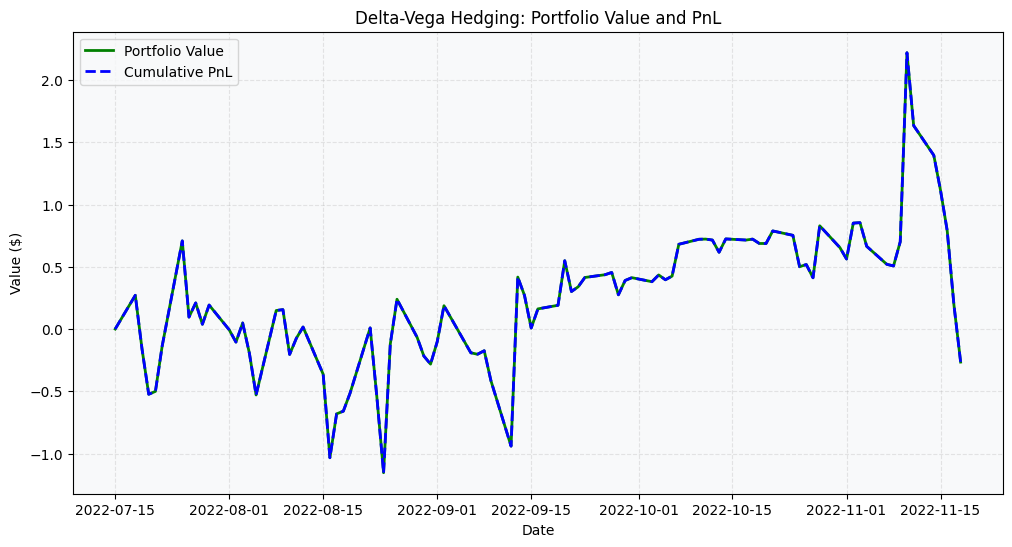

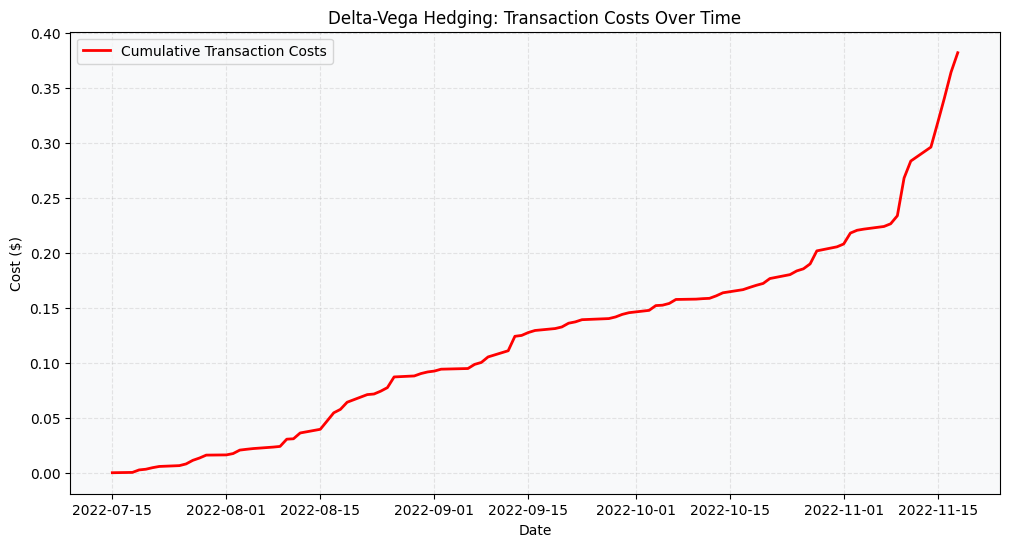

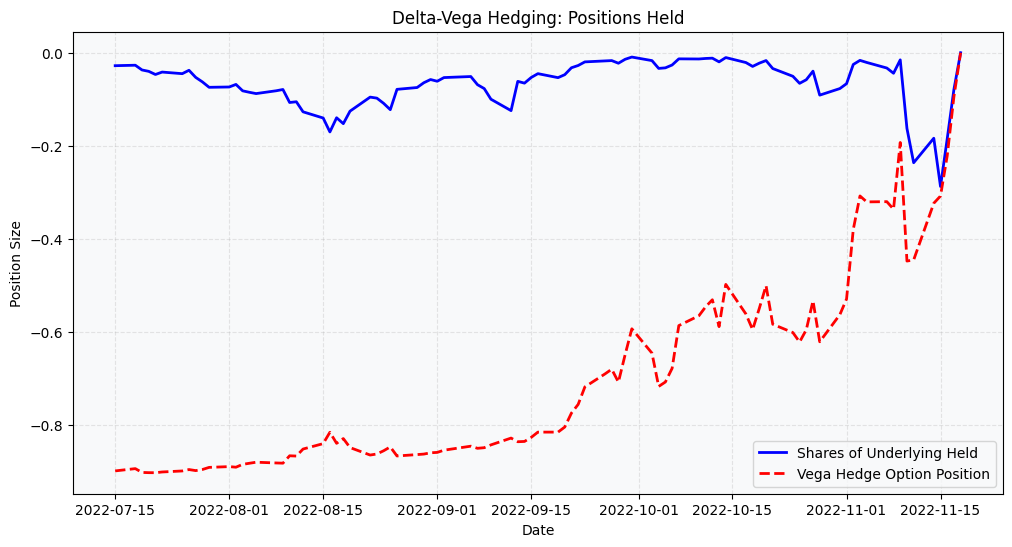

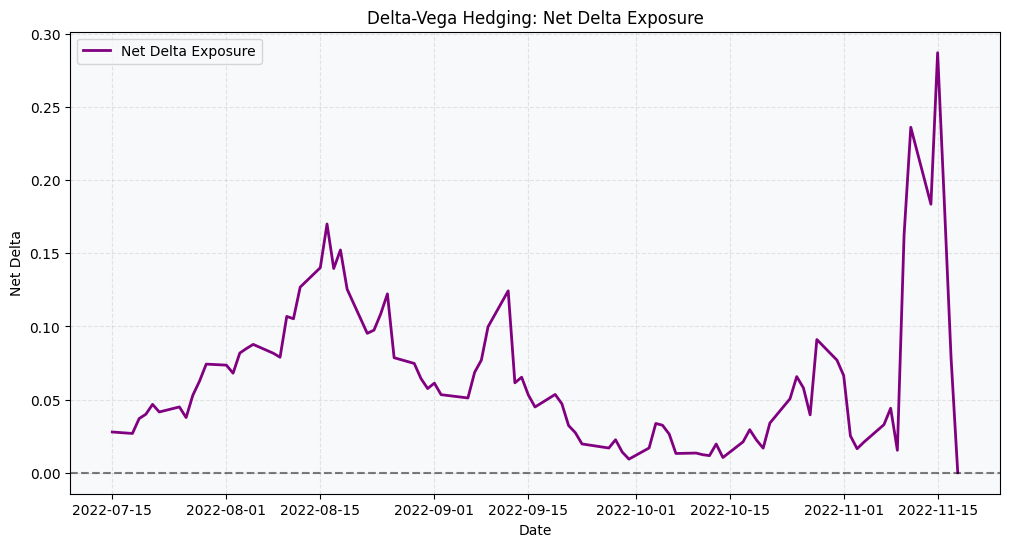

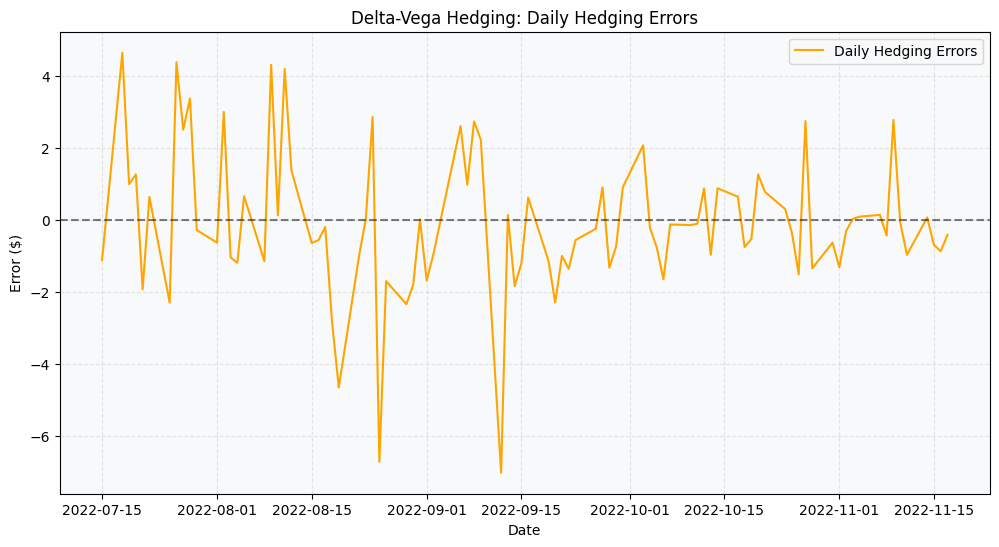

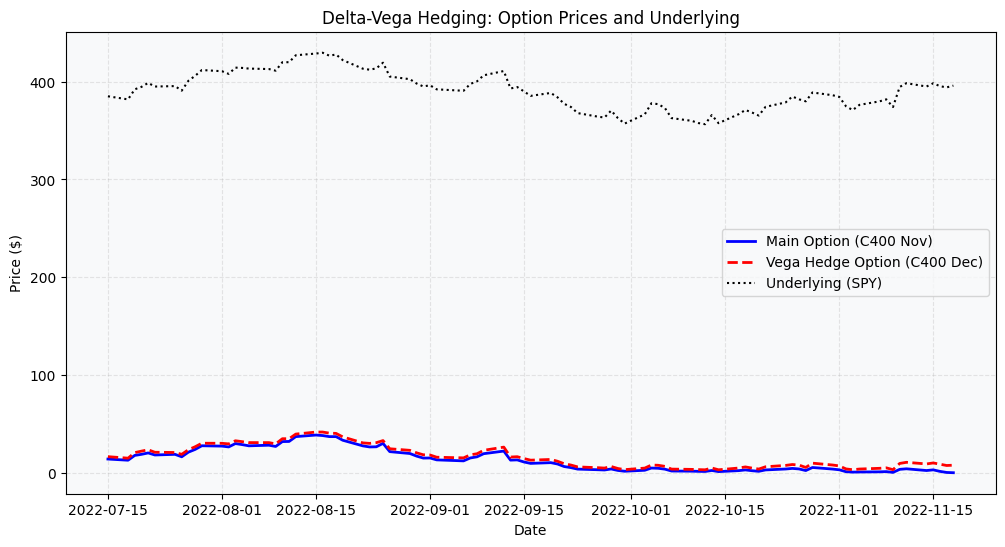

In [29]:
# Plot 1: Portfolio Value and Cumulative PnL
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, portfolio_values, 'g-', linewidth=2, label='Portfolio Value')
plt.plot(df_hedge.index, pnl, 'b--', linewidth=2, label='Cumulative PnL')
plt.title('Delta-Vega Hedging: Portfolio Value and PnL')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 2: Cumulative Transaction Costs
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, cumulative_costs, 'r-', linewidth=2, label='Cumulative Transaction Costs')
plt.title('Delta-Vega Hedging: Transaction Costs Over Time')
plt.xlabel('Date')
plt.ylabel('Cost ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 3: Positions Held Over Time
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, shares_held, 'b-', linewidth=2, label='Shares of Underlying Held')
plt.plot(df_hedge.index, option2_held, 'r--', linewidth=2, label='Vega Hedge Option Position')
plt.title('Delta-Vega Hedging: Positions Held')
plt.xlabel('Date')
plt.ylabel('Position Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 4: Net Delta Exposure Over Time
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, net_deltas, 'purple', linewidth=2, label='Net Delta Exposure')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Delta-Vega Hedging: Net Delta Exposure')
plt.xlabel('Date')
plt.ylabel('Net Delta')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 5: Daily Hedging Errors
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index[:-1], A_errors, 'orange', linewidth=1.5, label='Daily Hedging Errors')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.title('Delta-Vega Hedging: Daily Hedging Errors')
plt.xlabel('Date')
plt.ylabel('Error ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 6: Option Prices and Underlying
plt.figure(figsize=(12, 6))
plt.plot(df_hedge.index, OP1, 'b-', linewidth=2, label='Main Option (C400 Nov)')
plt.plot(df_hedge.index, df['C400_hedge'].values[start_idx:], 'r--', linewidth=2, label='Vega Hedge Option (C400 Dec)')
plt.plot(df_hedge.index, RE, 'k:', linewidth=1.5, label='Underlying (SPY)')
plt.title('Delta-Vega Hedging: Option Prices and Underlying')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Now to do a more in depth simulation that takes into account randomness and an actual portfolio,

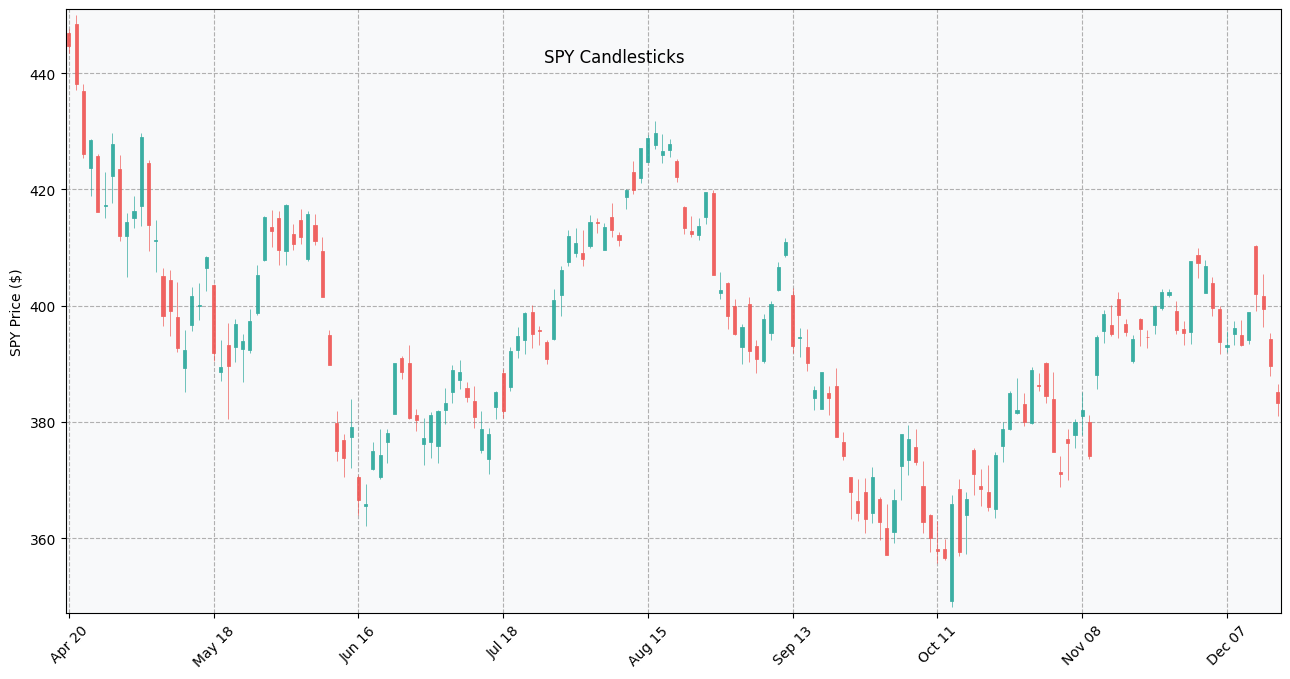

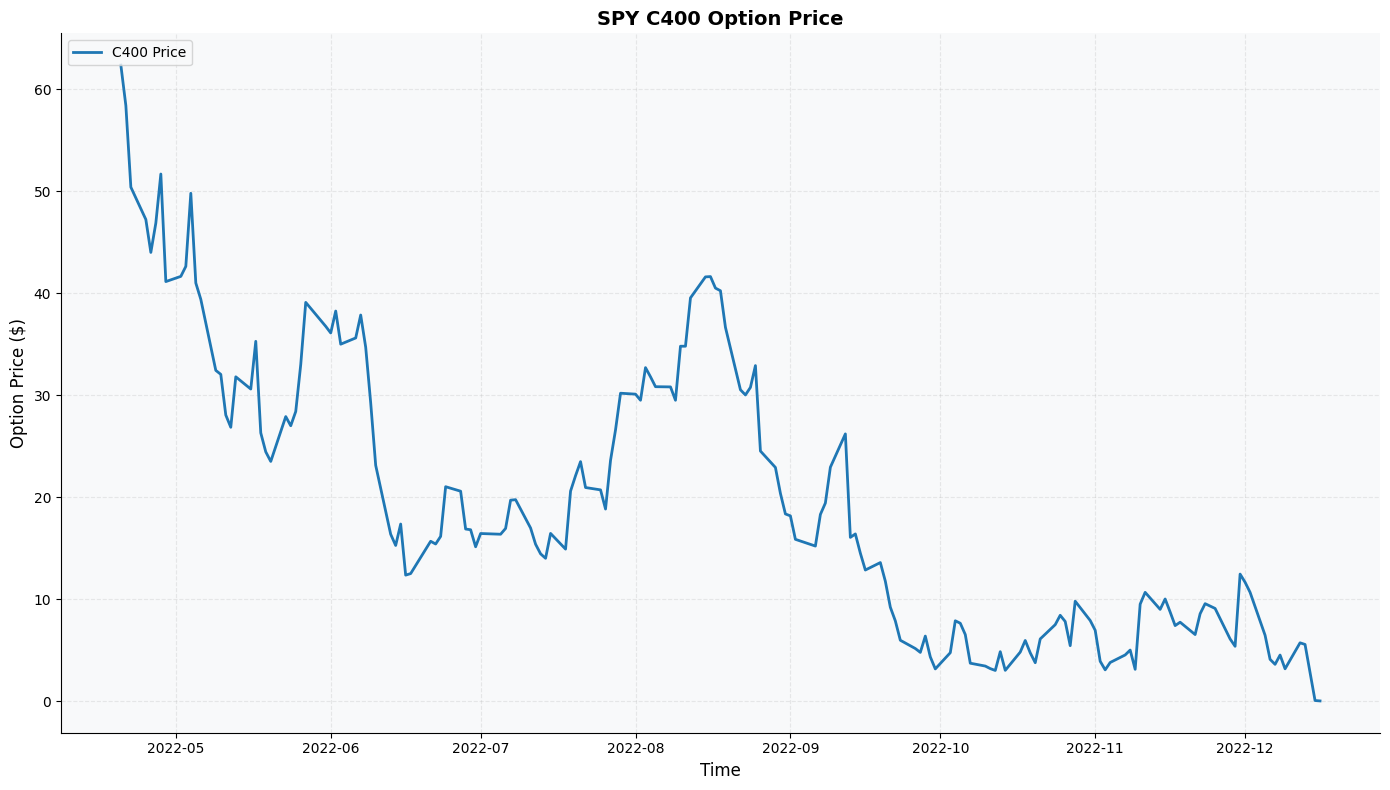

Data starts: 2022-04-20 00:00:00
Data ends: 2022-12-16 00:00:00
Number of days: 240
Number of data points: 168
Average points per day: 0.7


In [30]:
plot_spy_and_options("simulation_data/spy_221216_C380_C405.feather", ["C400"])

Loading simulation datasets...
Loaded spy_221118_C380_C405.feather: 136 days, maturity 2022-11-18
Loaded spy_220819_C380_C405.feather: 121 days, maturity 2022-08-19
Loaded spy_221216_C380_C405.feather: 168 days, maturity 2022-12-16
Loaded spy_220916_C380_C405.feather: 167 days, maturity 2022-09-16
Loaded spy_221014_C380_C405.feather: 31 days, maturity 2022-10-14
Found 26 strike prices: ['C380', 'C381', 'C382', 'C383', 'C384', 'C385', 'C386', 'C387', 'C388', 'C389', 'C390', 'C391', 'C392', 'C393', 'C394', 'C395', 'C396', 'C397', 'C398', 'C399', 'C400', 'C401', 'C402', 'C403', 'C404', 'C405']
Found 5 maturities
Total simulations: 130
Rehedging frequency: Every 1 day
Initial portfolio value: $100

Processing spy_220819_C380_C405.feather (maturity: 2022-08-19)
Strike 380 (OTM): MSE=0.187970, Costs=$  0.35, Final=$  96.51, Return= -3.49%
Strike 381 (OTM): MSE=1.695534, Costs=$  0.44, Final=$  97.75, Return= -2.25%
Strike 382 (OTM): MSE=0.667567, Costs=$  0.40, Final=$  97.80, Return= -2.20%

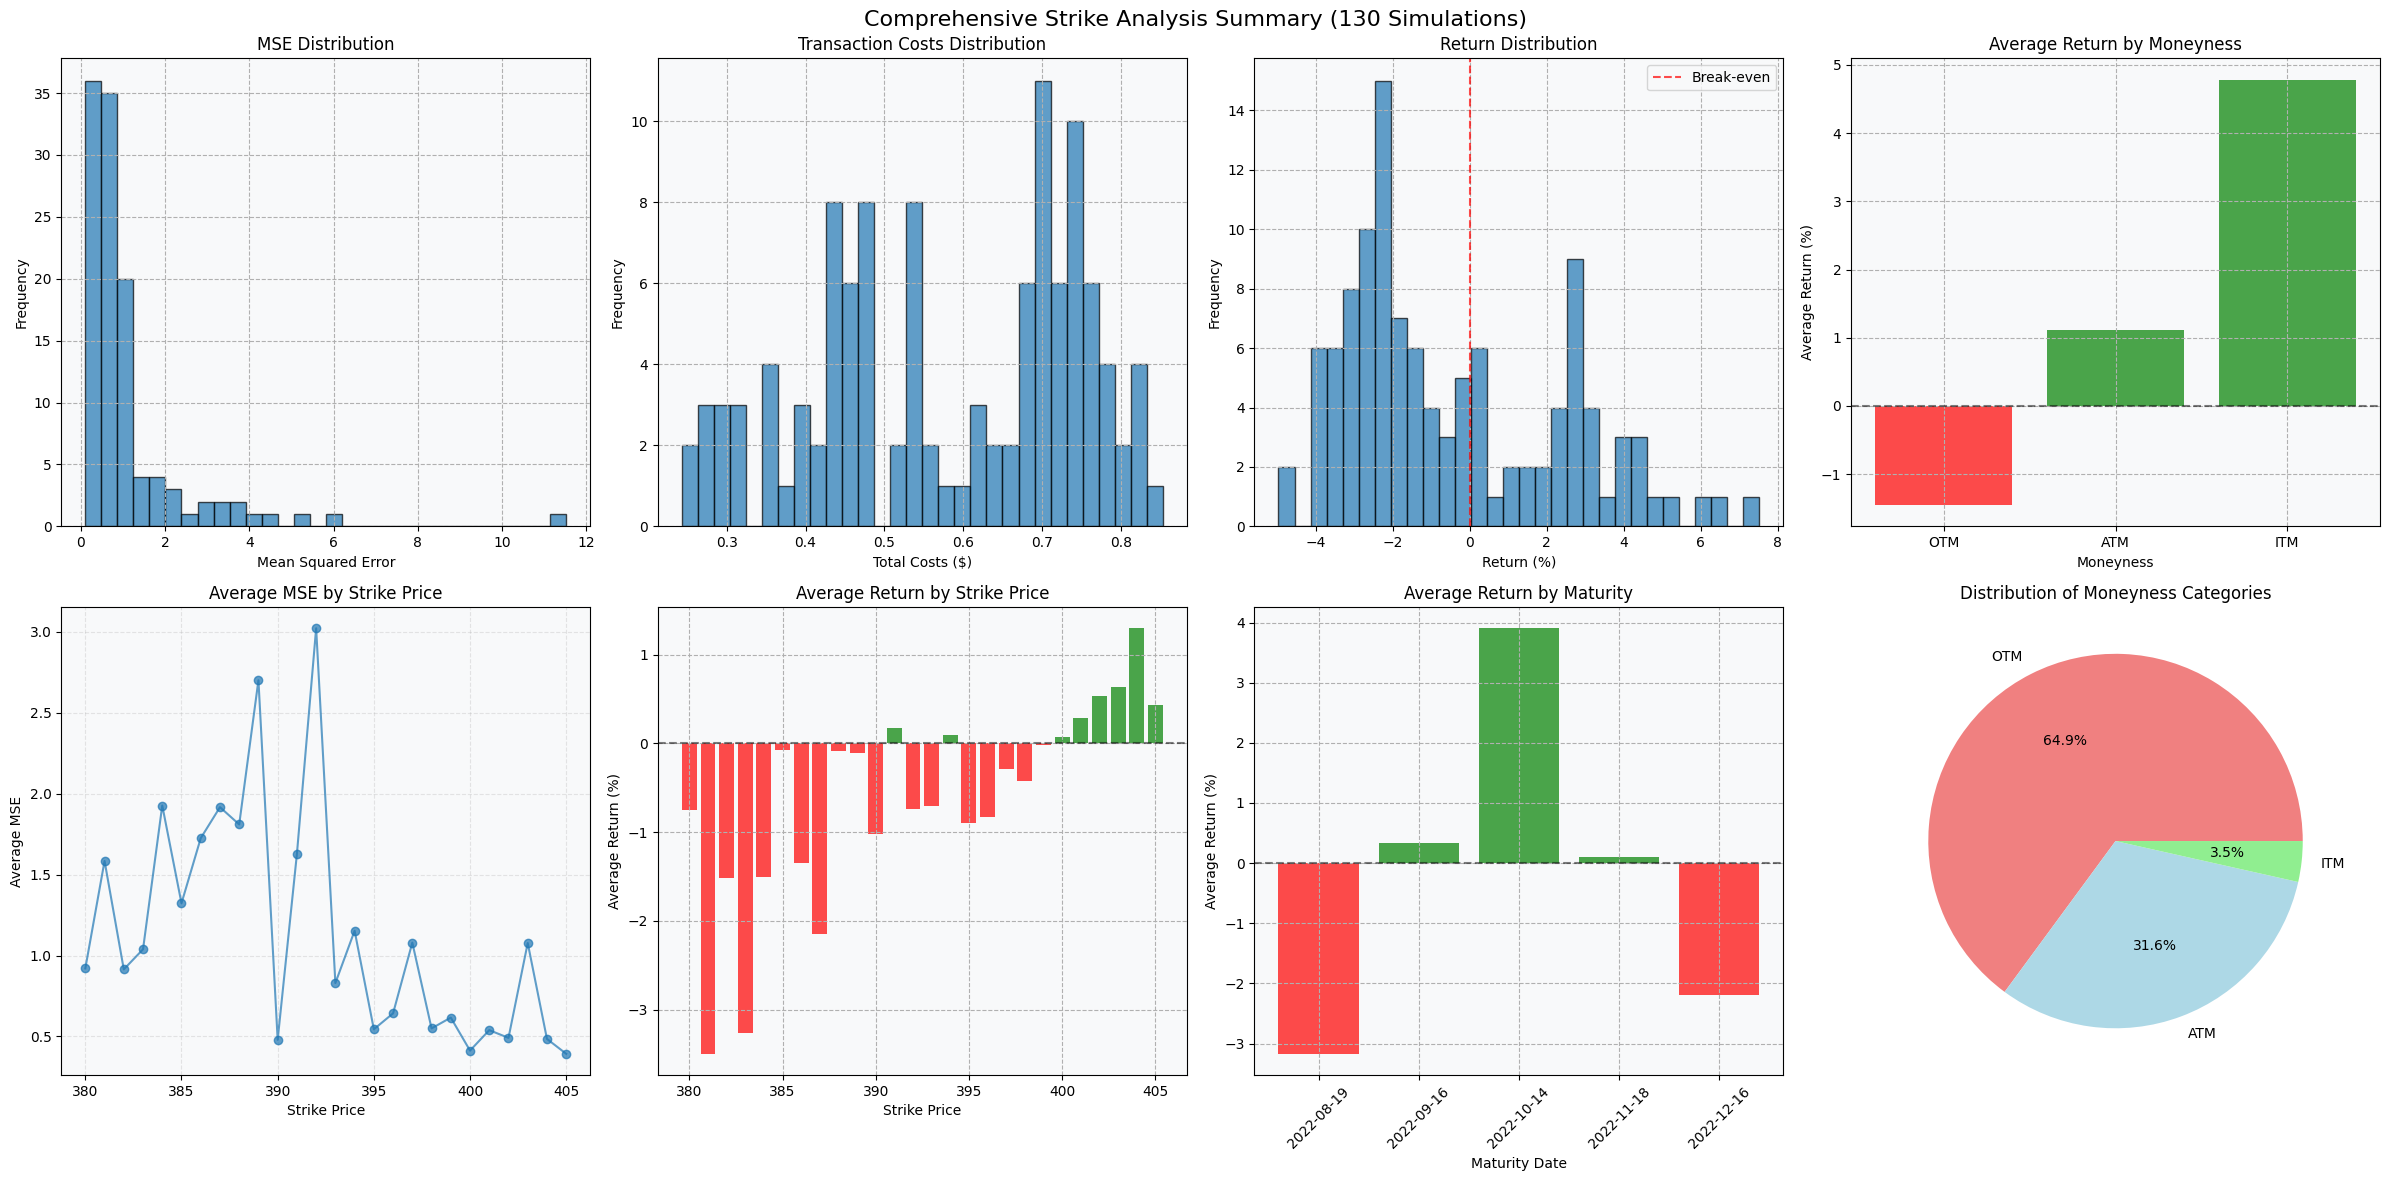

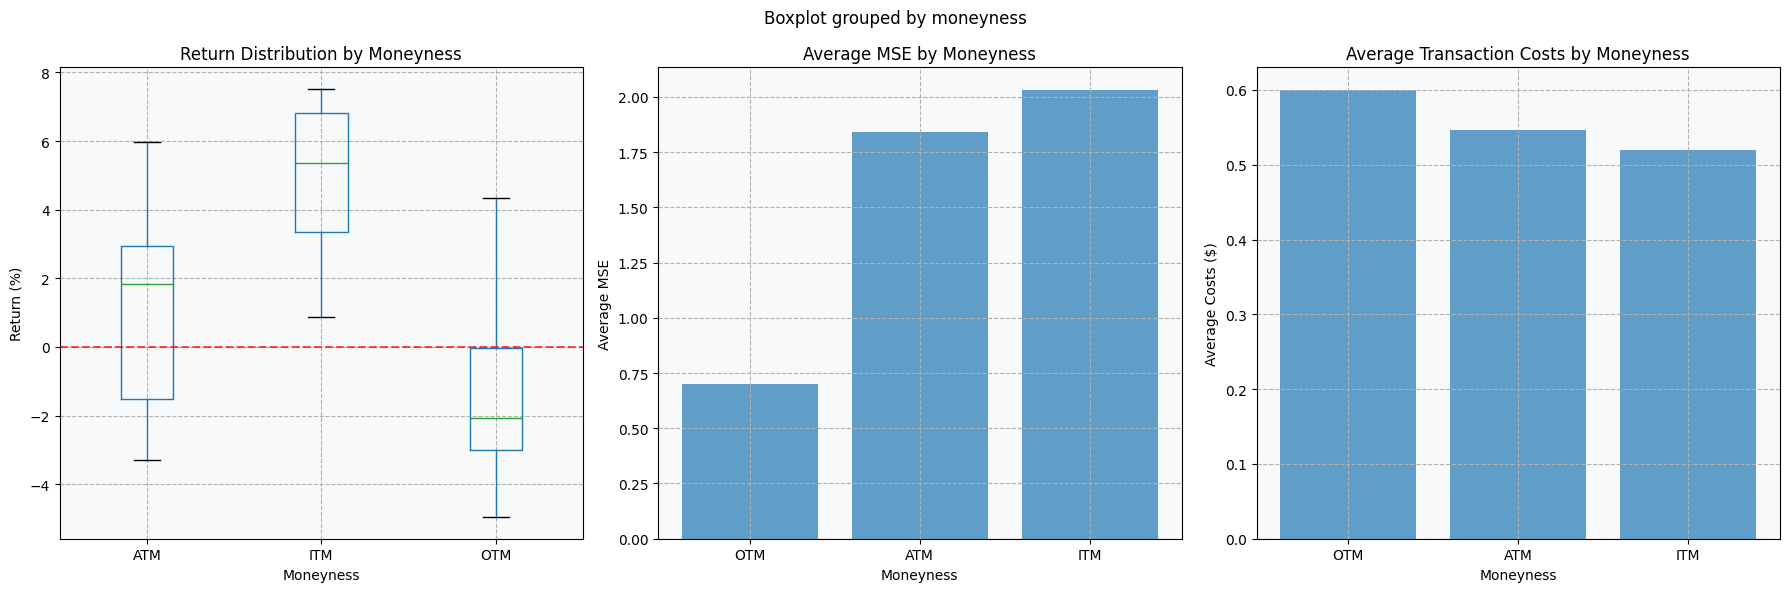

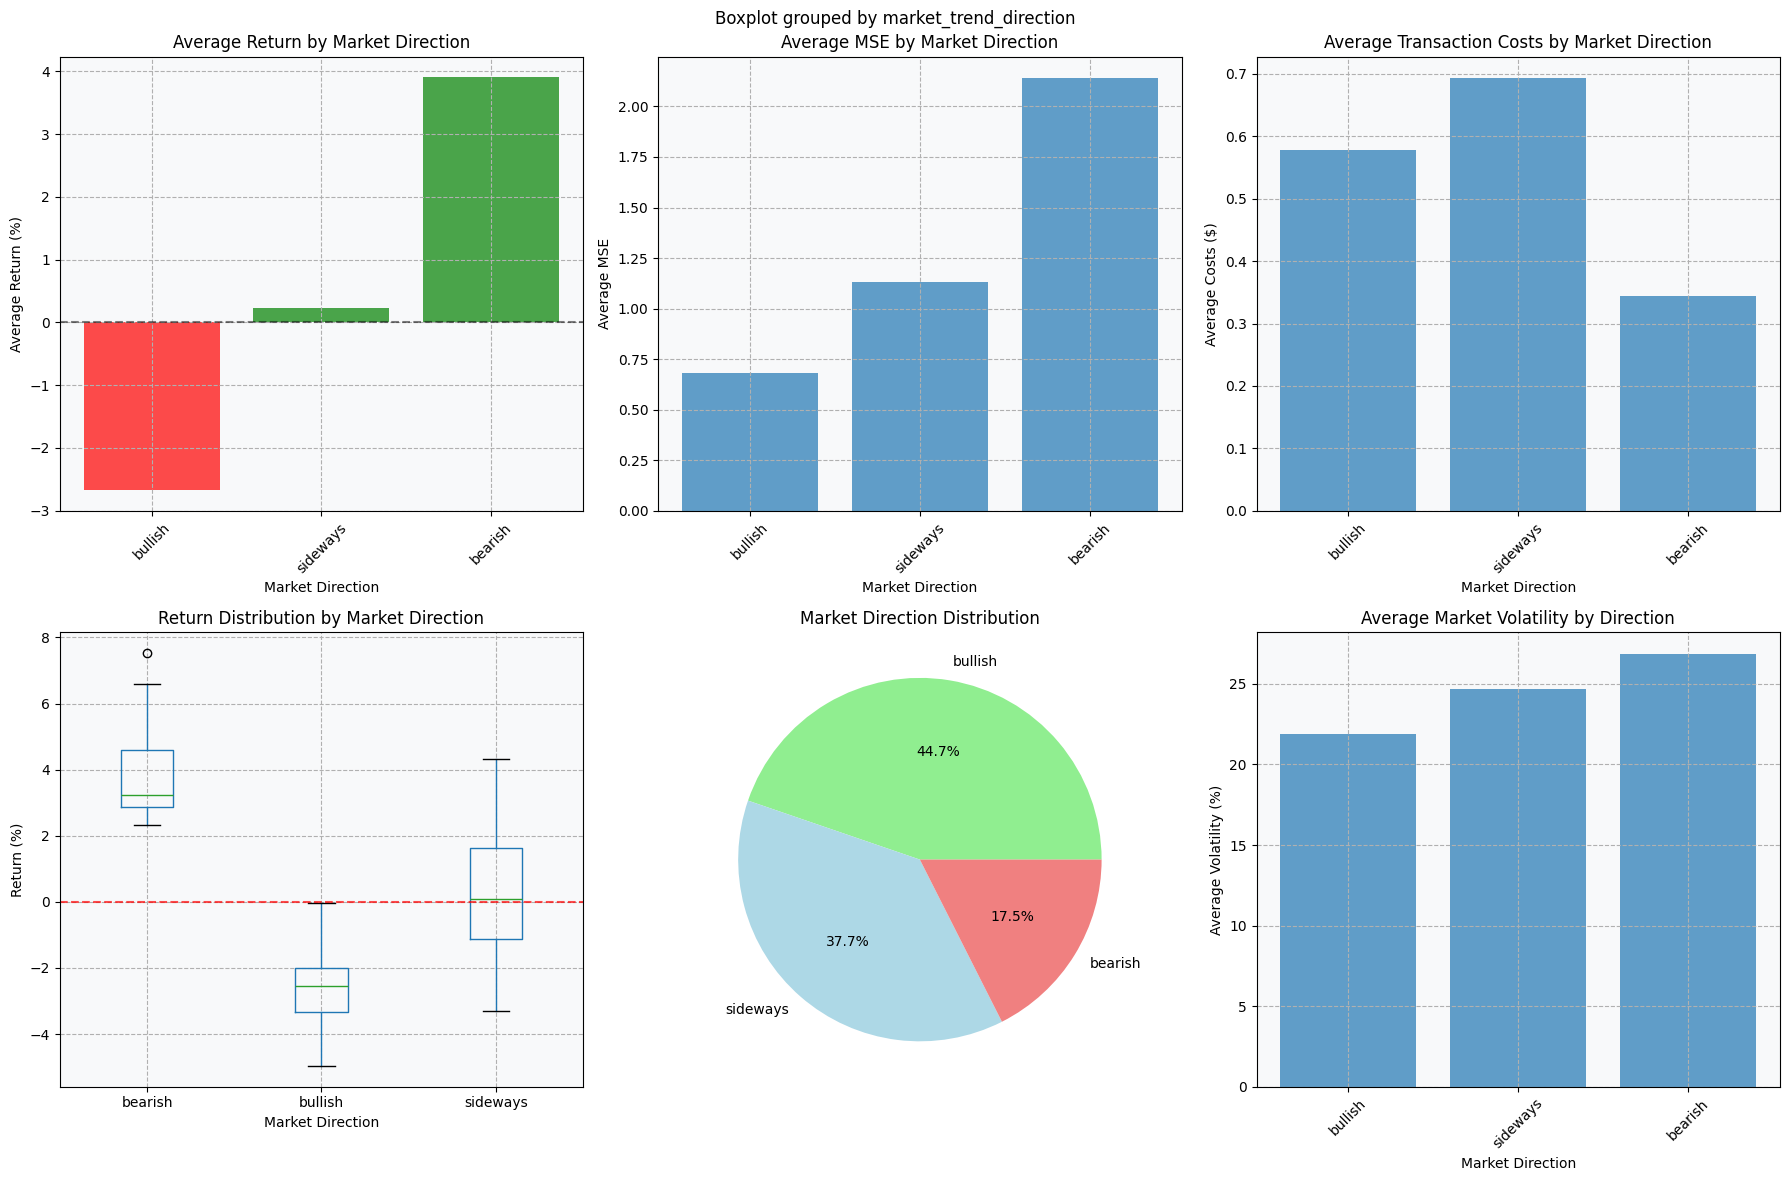


MARKET DIRECTION ANALYSIS
Performance by Market Direction:
                       return_pct                                   mse  \
                             mean     std count     min     max    mean   
market_trend_direction                                                    
bearish                    3.9042  1.4699    20  2.3367  7.5255  2.1391   
bullish                   -2.6728  0.9644    51 -4.9676 -0.0226  0.6802   
sideways                   0.2236  2.0065    43 -3.2941  4.3289  1.1329   

                               total_costs         market_volatility          \
                           std        mean     std              mean     std   
market_trend_direction                                                         
bearish                 2.7008      0.3449  0.0822           26.8491  0.0000   
bullish                 0.5807      0.5776  0.1393           21.8699  2.9163   
sideways                1.1486      0.6929  0.0969           24.6754  2.7427   

        

In [31]:
import statistical_hedging_analysis as sha

# Run comprehensive analysis with moneyness classification
comprehensive_stats = sha.run_comprehensive_strike_analysis()
